In [2]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [3]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce ETV Result for KIC 5264818

- also known as TIC 121732964 

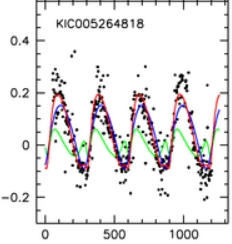

(x, time-span: ~1300 d ; y, O-C in kilosecs)

Source:  `2013ApJ...768...33R` [Triple-star Candidates among the Kepler Binaries](https://ui.adsabs.harvard.edu/abs/2013ApJ...768...33R/abstract) 


In [4]:
# define the plotting parameters

figsize = (8,4)

In [5]:
# import the data

# choose a TIC ID to analyze
ticid = 121732964
kicid = 5264818  # ETV amplitude ~300s
# reference: 2013ApJ
# 
# TODO: consider to include Kepler data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u



sr = lk.search_lightcurve('KIC{}'.format(kicid))
sr = sr[sr.exptime == 1800 * u.s]  # exclude 1 quarter that has both 30min and 1min cadence data
sr = lke._sort_chronologically(sr)
display(sr)
lcc_kplr = sr.download_all()
lc_kplr = lcc_kplr[:].stitch()
lc_kplr.time.format = "mjd"  # to be consistent with the paper result, also for ease of combining with TESS data
lc_kplr = lc_kplr.truncate(None, 55800)  # test with ~2 ETV cycles based on reference plot

sr = lk.search_lightcurve('TIC {}'.format(ticid), author="SPOC")  # all available TESS sectors has short cadence data
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
lc_tess.time.format = "mjd"

search_result = lk.LightCurveCollection([
    lc_kplr,
    lc_tess,
]).stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 18 data products.

 #       mission      year author exptime  target_name  distance proposal_id
                                     s                   arcsec             
--- ----------------- ---- ------ ------- ------------- -------- -----------
  0 Kepler Quarter 00 2009 Kepler    1800 kplr005264818      0.0          EX
  1 Kepler Quarter 01 2009 Kepler    1800 kplr005264818      0.0          EX
  2 Kepler Quarter 02 2009 Kepler    1800 kplr005264818      0.0          EX
  3 Kepler Quarter 03 2009 Kepler    1800 kplr005264818      0.0          EX
  4 Kepler Quarter 04 2010 Kepler    1800 kplr005264818      0.0          EX
  5 Kepler Quarter 05 2010 Kepler    1800 kplr005264818      0.0          EX
  6 Kepler Quarter 06 2010 Kepler    1800 kplr005264818      0.0          EX
  7 Kepler Quarter 07 2010 Kepler    1800 kplr005264818      0.0          EX
  8 Kepler Quarter 08 2011 Kepler    1800 kplr005264818      0.0          EX
  9 Kepler Quarter 09 2011 Kepler    1800 kplr005264818      0.0          EX
 10 Kepler Quarter 10 2011 Kepler    1800 kplr005264818      0.0          EX
 11 Kepler Quarter 11 2012 Kepler    1800 kplr005264818      0.0          EX
 12 Kepler Quarter 12 2012 Kepler    1800 kplr005264818      0.0          EX
 13 Kepler Quarter 13 2012 Kepler    1800 kplr005264818      0.0          EX
 14 Kepler Quarter 14 2012 Kepler    1800 kplr005264818      0.0          EX
 15 Kepler Quarter 15 2013 Kepler    1800 kplr005264818      0.0          EX
 16 Kepler Quarter 16 2013 Kepler    1800 kplr005264818      0.0          EX
 17 Kepler Quarter 17 2013 Kepler    1800 kplr005264818      0.0          EX

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 14 2019   SPOC     120   121732964      0.0     G022062
  1 TESS Sector 40 2021   SPOC     120   121732964      0.0      G04171
  2 TESS Sector 41 2021   SPOC     120   121732964      0.0      G04171
  3 TESS Sector 54 2022   SPOC     120   121732964      0.0      G04171
  4 TESS Sector 55 2022   SPOC     120   121732964      0.0      G04171

131193

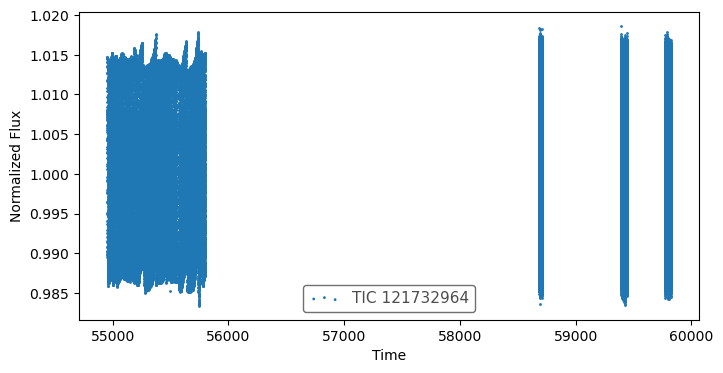

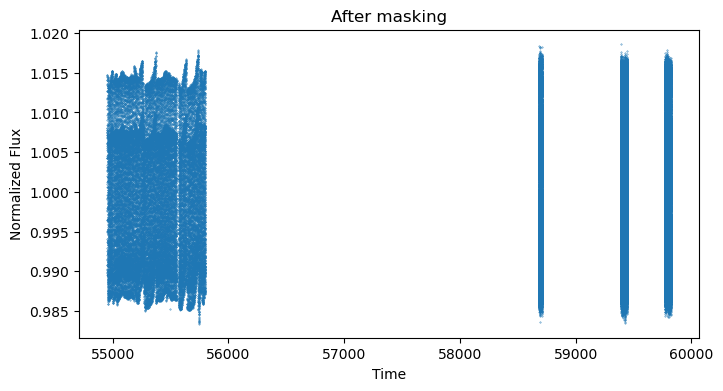

In [6]:
%matplotlib inline
# %matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)


mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

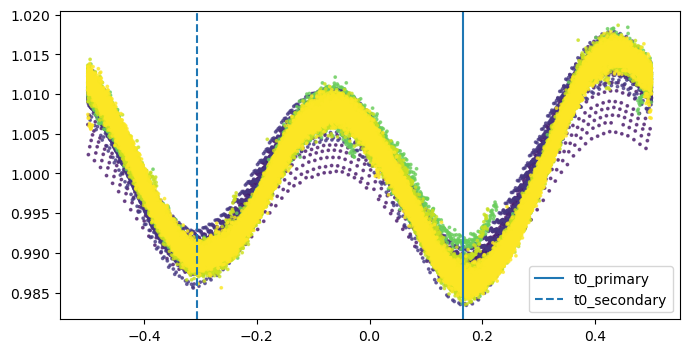

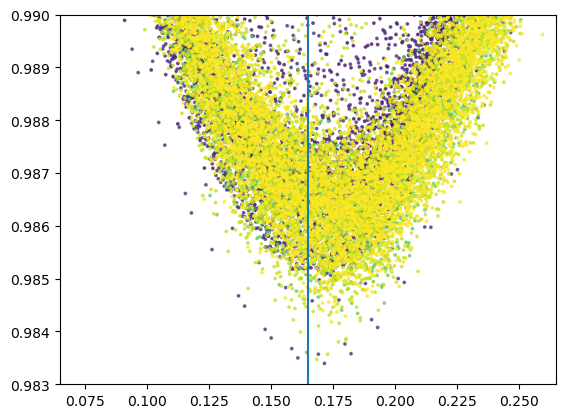

In [7]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# period = 1.9050502  # Kepler EB Period
period = 1.905052  # 2013ApJ Period


t0_primary = 54955.233438 - 0.5  # Kepler EB, the MJD there seems to be off by 0.5
t0_secondary = t0_primary + period * 0.5290


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 0.2229 * period * 24  # used for the window to cut the lighcurve around eclipses in later cells
duration_hr_secondary = 0.2353 * period * 24  

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.35  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.10, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.10);
plt.ylim(0.983, 0.990);
plt.show()

### Now that the data is ready we can start 

In [105]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0       54953.039373  0.997629  0.000012  0.275601
1       54953.059808  0.999240  0.000012  0.286328
2       54953.080242  1.000963  0.000012  0.297054
3       54953.100677  1.002607  0.000012  0.307781
4       54953.121111  1.004313  0.000012  0.318507
...              ...       ...       ...       ...
131131  59823.759721  1.000218  0.000531  0.014393
131132  59823.761110  1.000160  0.000531  0.015122
131133  59823.762499  0.999718  0.000531  0.015851
131134  59823.763887  0.999513  0.000531  0.016580
131135  59823.765276  0.999866  0.000531  0.017309

[131136 rows x 4 columns]

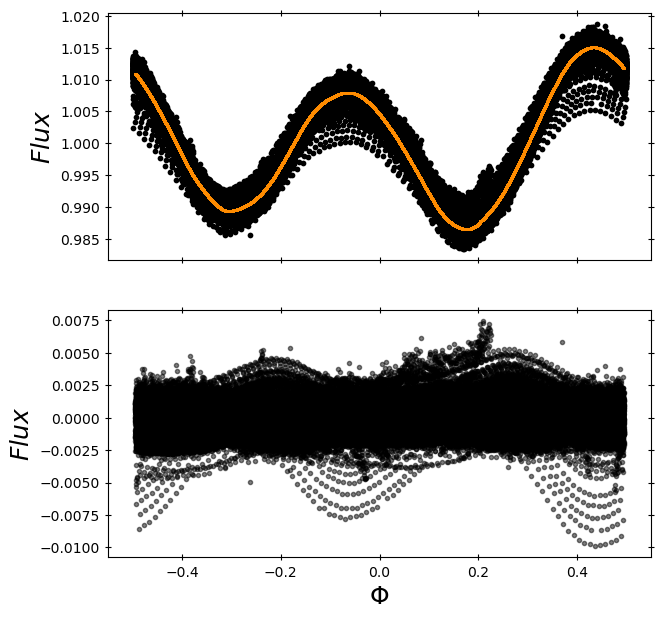

time      flux       err     phase  flux_sub_binary  \
0       54953.039373  0.997629  0.000012  0.275601         0.001900   
1       54953.059808  0.999240  0.000012  0.286328         0.001780   
2       54953.080242  1.000963  0.000012  0.297054         0.001720   
3       54953.100677  1.002607  0.000012  0.307781         0.001566   
4       54953.121111  1.004313  0.000012  0.318507         0.001464   
...              ...       ...       ...       ...              ...   
131131  59823.759721  1.000218  0.000531  0.014393        -0.002879   
131132  59823.761110  1.000160  0.000531  0.015122        -0.002859   
131133  59823.762499  0.999718  0.000531  0.015851        -0.003222   
131134  59823.763887  0.999513  0.000531  0.016580        -0.003350   
131135  59823.765276  0.999866  0.000531  0.017309        -0.002919   

        binary_model  
0           0.995728  
1           0.997461  
2           0.999243  
3           1.001041  
4           1.002849  
...              ...  
131131      1.003097  
131132      1.003019  
131133      1.002941  
131134      1.002863  
131135      1.002785  

[131136 rows x 6 columns]

In [106]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 129837 901
reached the end
10 128727 901
reached the end
10 128342 901
reached the end
10 128127 901
reached the end
10 127991 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0       54953.039373  0.997629  0.000012  0.275601         0.001900   
1       54953.059808  0.999240  0.000012  0.286328         0.001780   
2       54953.080242  1.000963  0.000012  0.297054         0.001720   
3       54953.100677  1.002607  0.000012  0.307781         0.001566   
4       54953.121111  1.004313  0.000012  0.318507         0.001464   
...              ...       ...       ...       ...              ...   
131131  59823.759721  1.000218  0.000531  0.014393        -0.002879   
131132  59823.761110  1.000160  0.000531  0.015122        -0.002859   
131133  59823.762499  0.999718  0.000531  0.015851        -0.003222   
131134  59823.763887  0.999513  0.000531  0.016580        -0.003350   
131135  59823.765276  0.999866  0.000531  0.017309        -0.002919   

        binary_model  flux_detrended  
0           0.995728        0.996248  
1           0.997461        0.997870  
2           0.999243        0.999604  
3           1.001041        1.001259  
4           1.002849        1.002975  
...              ...             ...  
131131      1.003097        1.002875  
131132      1.003019        1.002874  
131133      1.002941        1.002490  
131134      1.002863        1.002336  
131135      1.002785        1.002739  

[131136 rows x 7 columns]

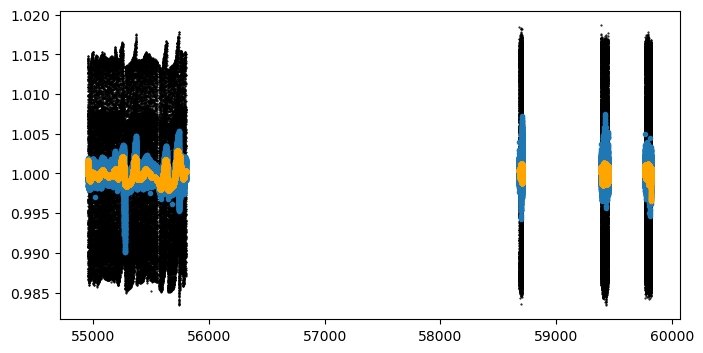

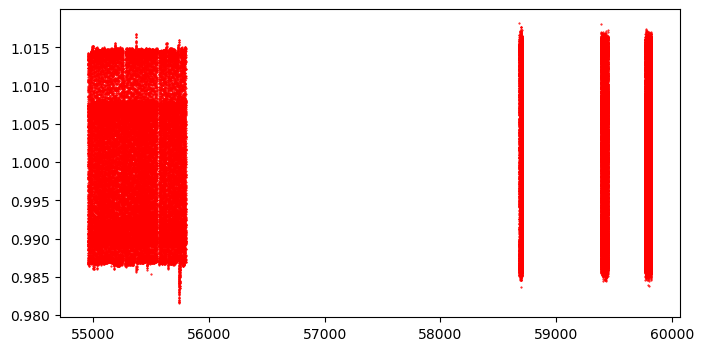

In [107]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

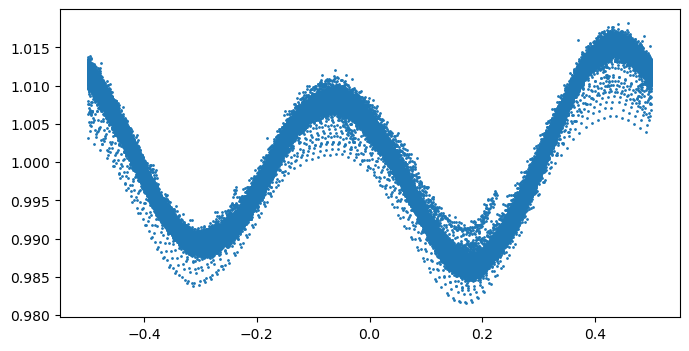

In [108]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   54954.733438 0.16485000000256378
window_width_p (phase): 0.144885
Secondary: 54953.836158508 -0.3061499999998508
window_width_s (phase): 0.152945


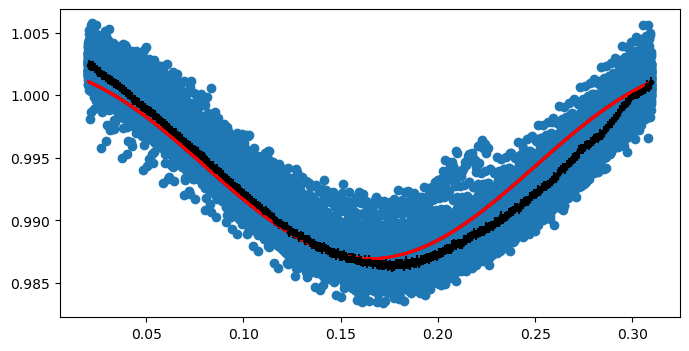

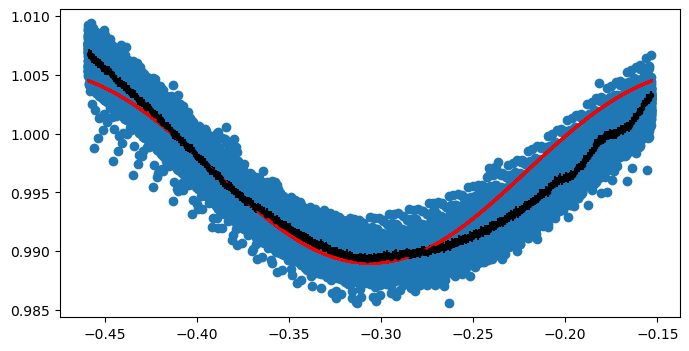

In [8]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.65 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    window_width_s = 0.65 * duration_hr_secondary / 24 / period
    # window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.003, -0.016, midpoint_p, 0.08, 1.0]
start_vals_s = [1.006, -0.017, midpoint_s, 0.08, 1.0]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [10]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = False

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

Use pre-defined inital model params:


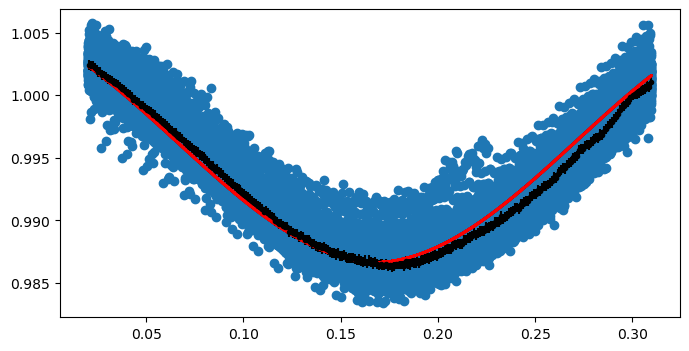

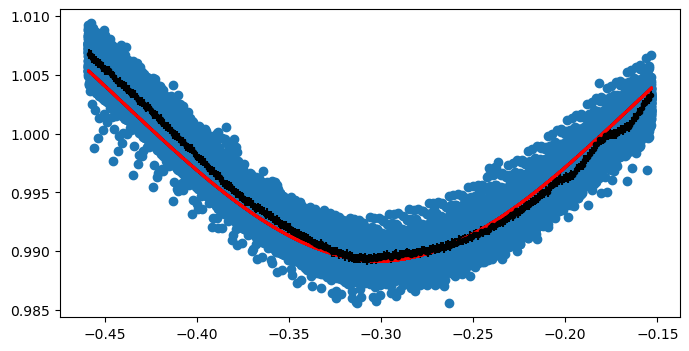

In [11]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")

    # initial fit params from Kepler data (<MJD 55800) 2013Apj Period
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0079770953810983, -0.021266856349716978, 0.1679917286817513, 0.10103761588580798, 0.9377701388816556
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.017958545579376, -0.02877616684866633, -0.30112563808942394, 0.13300990936997456, 0.9516544755371867

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [111]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0079770953810983, -0.021266856349716978, 0.1679917286817513, 0.10103761588580798, 0.9377701388816556
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.017958545579376, -0.02877616684866633, -0.30112563808942394, 0.13300990936997456, 0.9516544755371867


2556

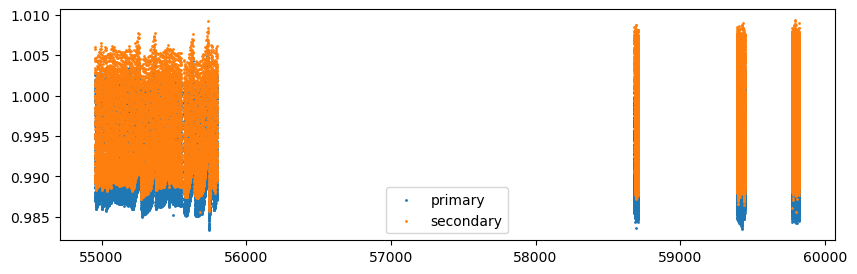

In [112]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

54954.733438 1.905052 54954.733438


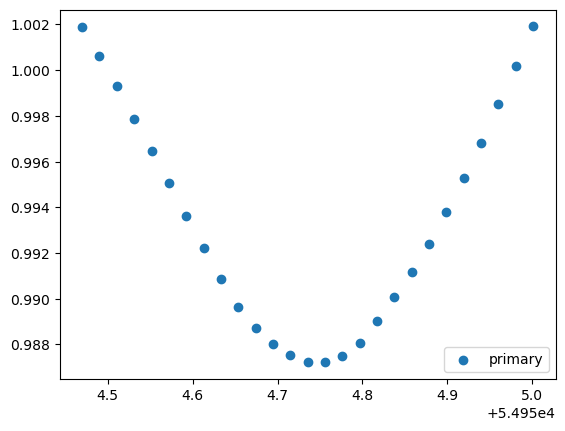

54954.733438 1.905052 54956.638490000005


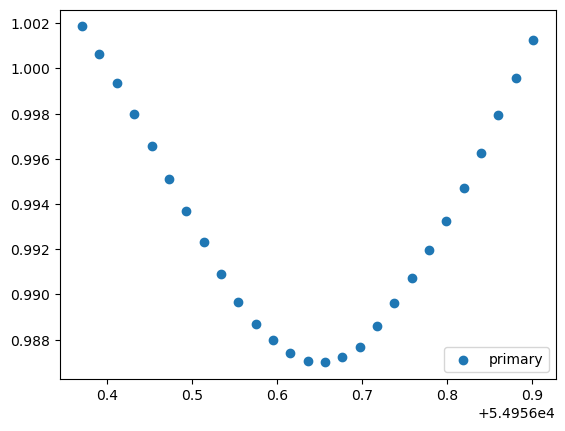

54954.733438 1.905052 54958.543542


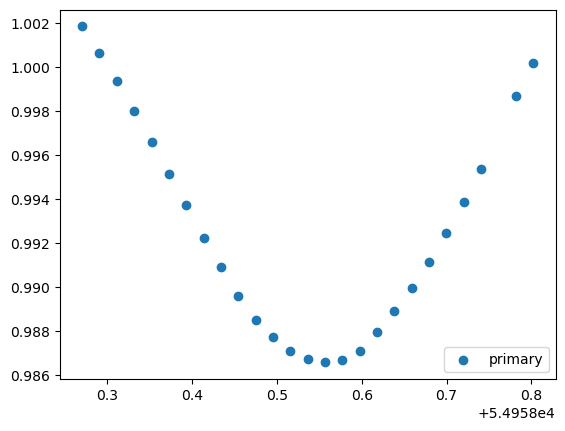

54953.836158508 1.905052 54953.836158508


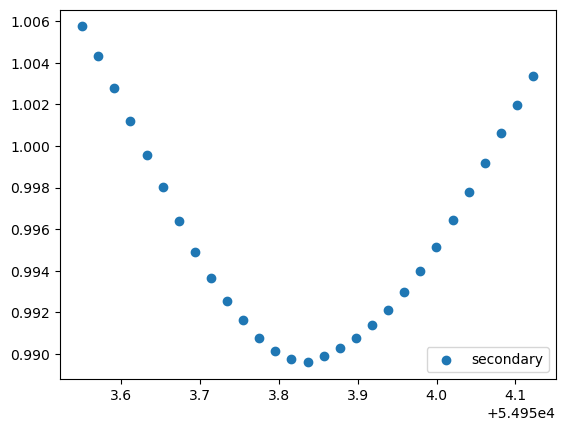

54953.836158508 1.905052 54955.741210508


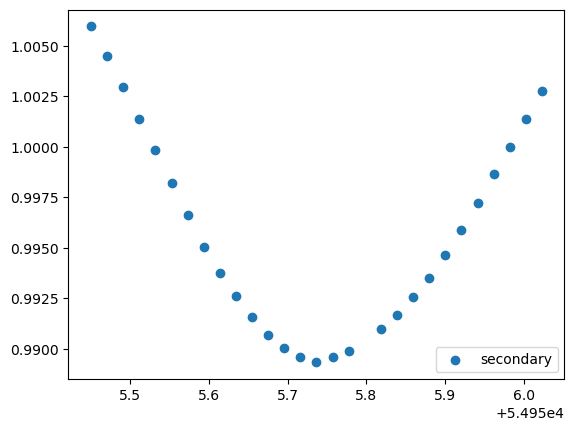

54953.836158508 1.905052 54957.646262507995


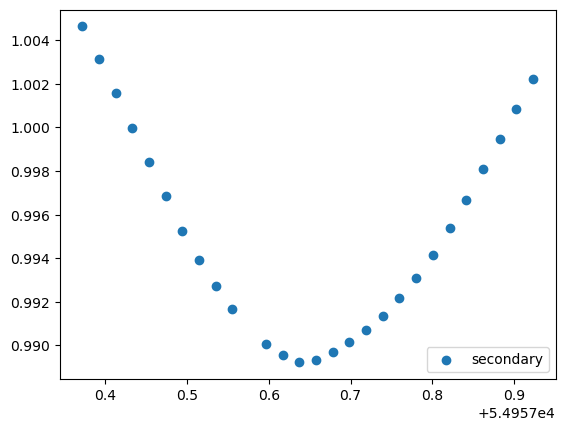

In [113]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has al

100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.25it/s]


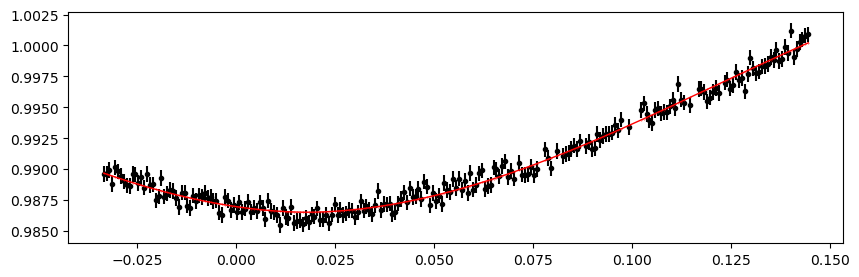

58684.825254 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 229.12it/s]


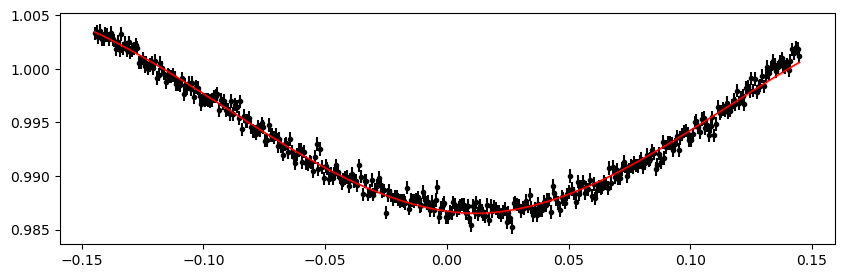

58686.730306000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 229.08it/s]


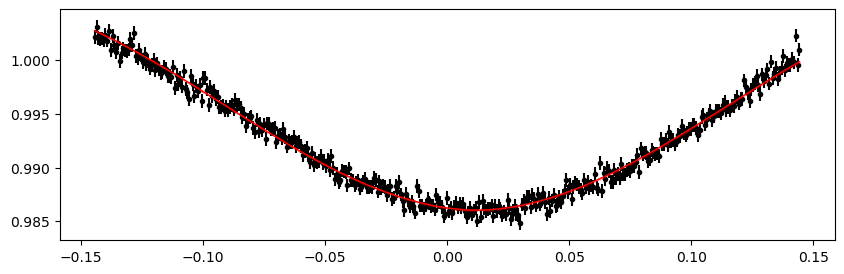

58688.635358 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 222.57it/s]


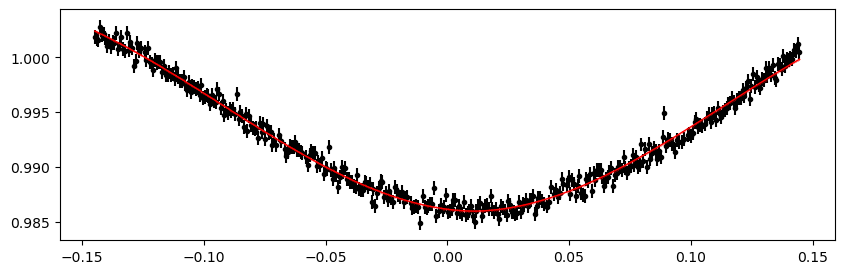

58690.54041 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 223.60it/s]


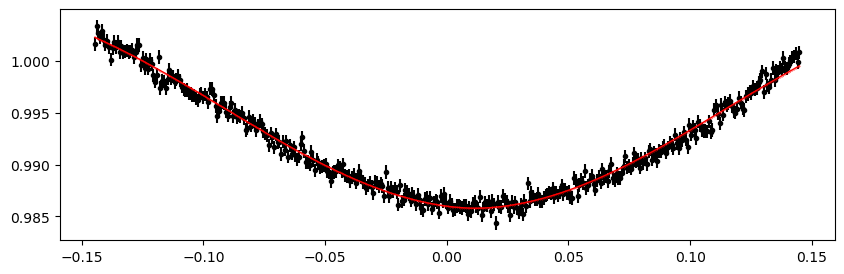

58692.445462 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 229.60it/s]


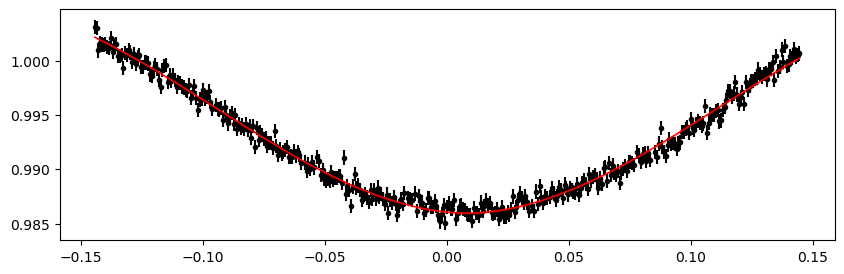

58694.350514000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 214.86it/s]


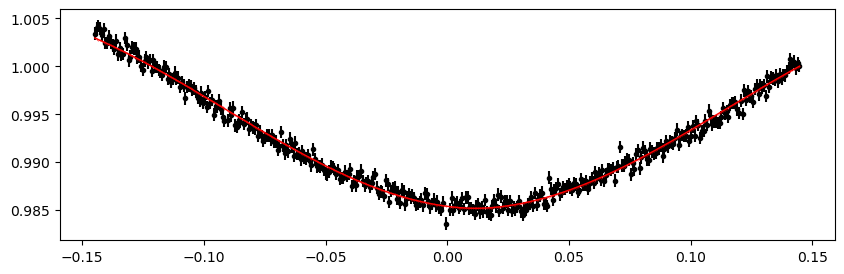

58698.160618 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 228.39it/s]


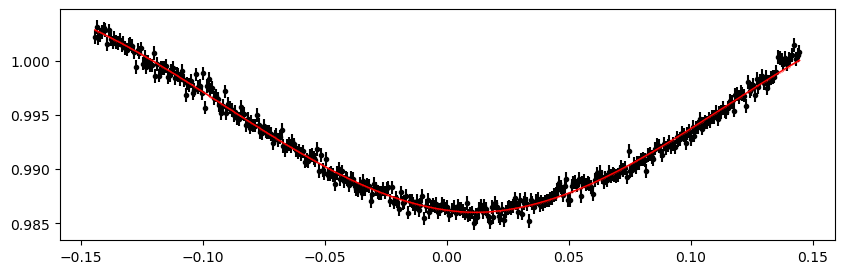

58700.06567 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 229.77it/s]


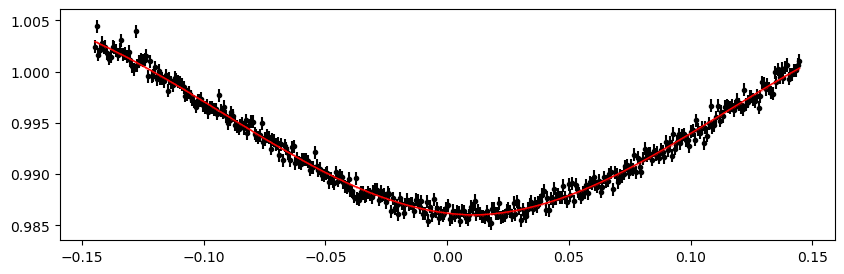

58701.970722000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 233.45it/s]


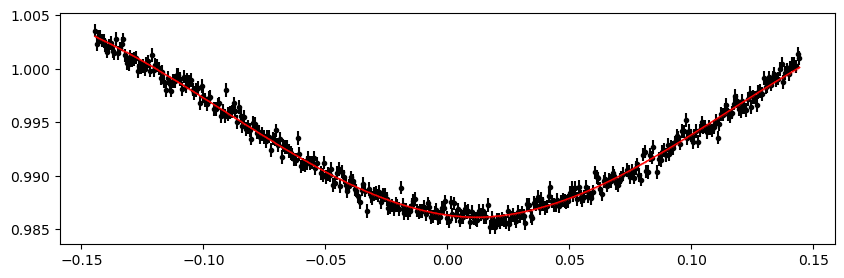

58703.875774 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 231.21it/s]


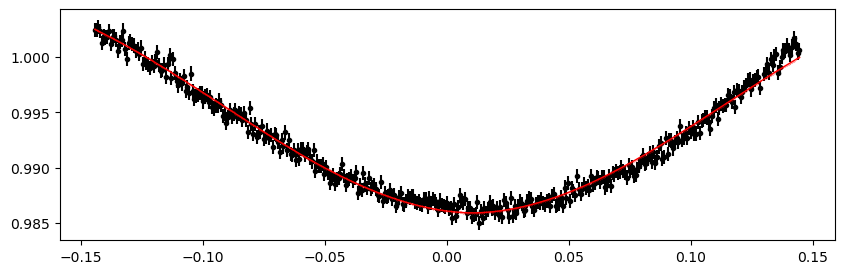

58705.780826 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 222.31it/s]


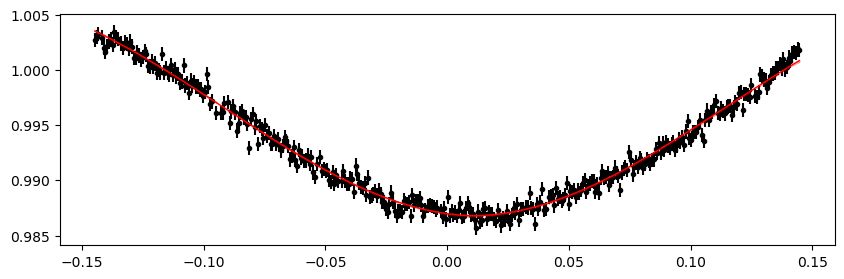

58707.685878000004 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:47<00:00, 209.51it/s]


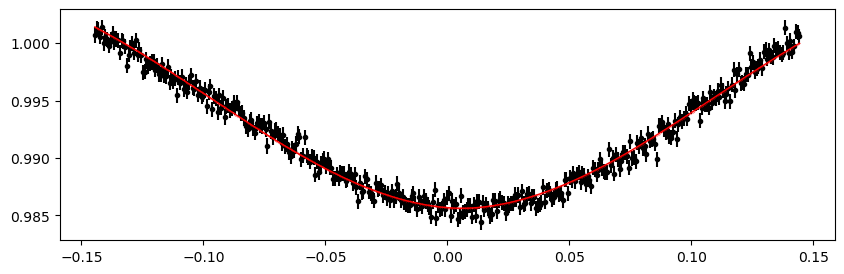

58709.590930000006 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 219.10it/s]


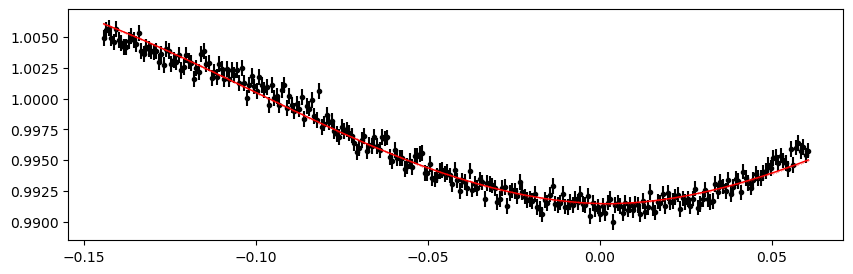

59391.599546000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 242.91it/s]


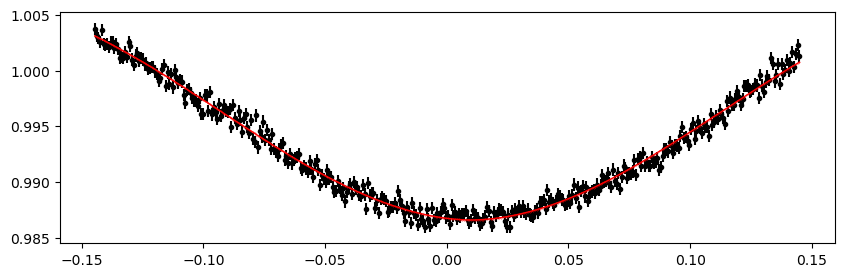

59393.504598 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.00it/s]


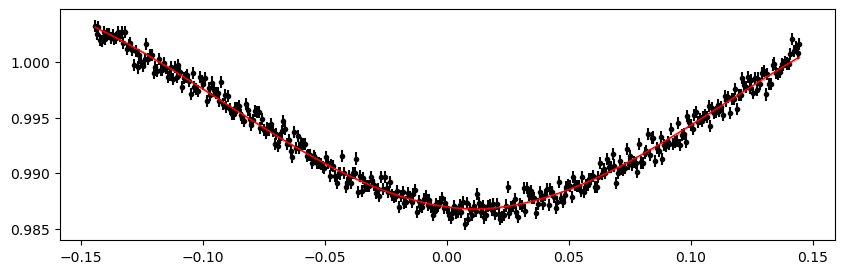

59395.40965 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.14it/s]


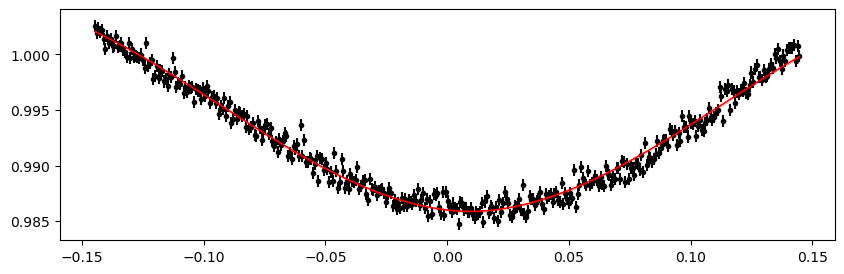

59397.314702 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 247.42it/s]


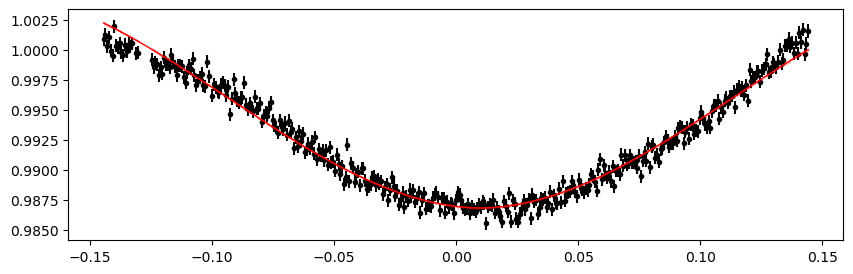

59399.219754000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 238.07it/s]


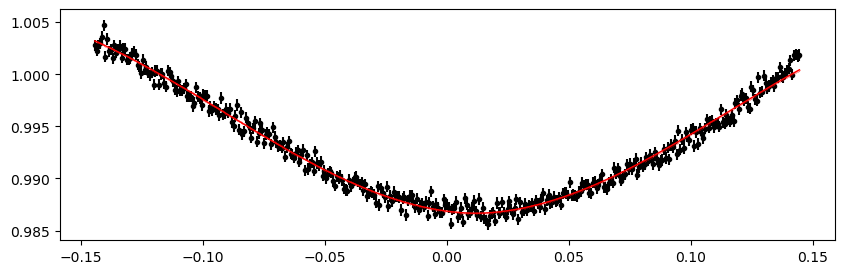

59401.124806 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 220.75it/s]


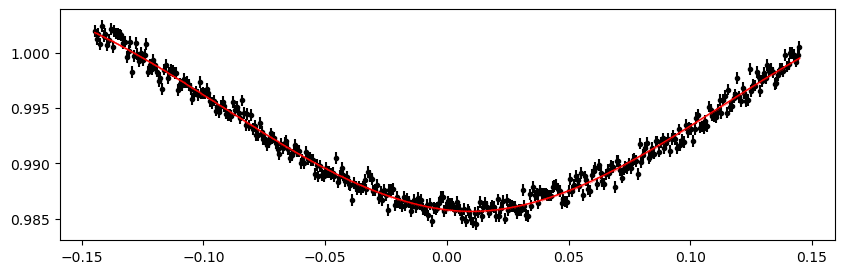

59403.029858 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.76it/s]


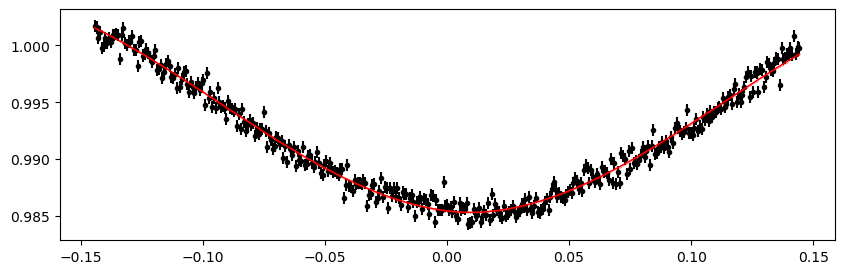

59404.93491 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 247.31it/s]


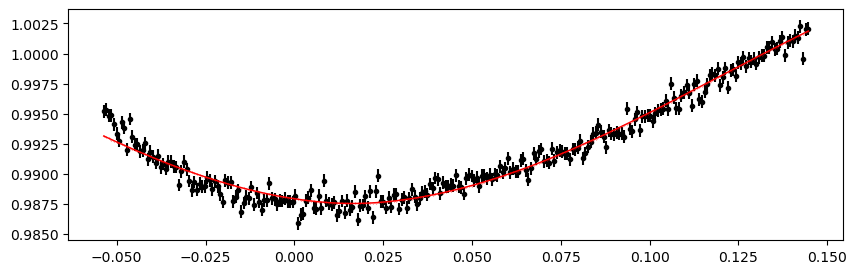

59406.839962000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 238.97it/s]


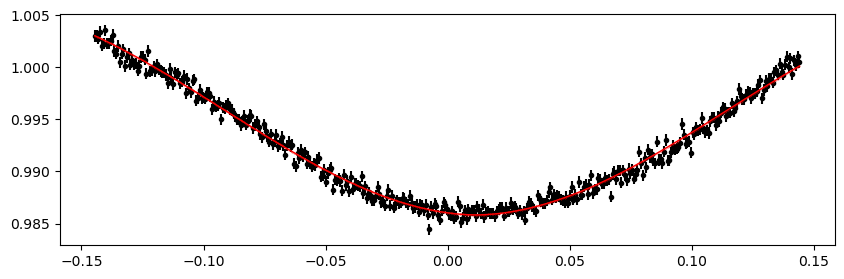

59408.745014 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.71it/s]


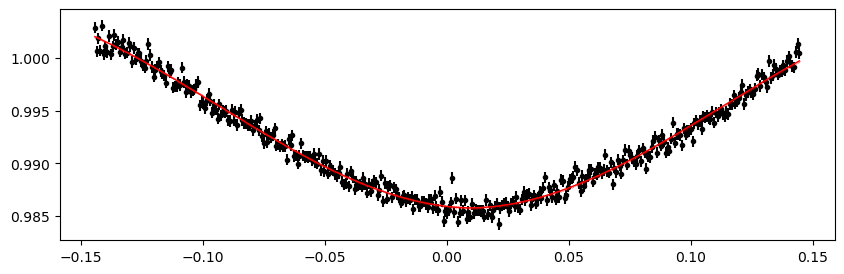

59410.650066 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 234.98it/s]


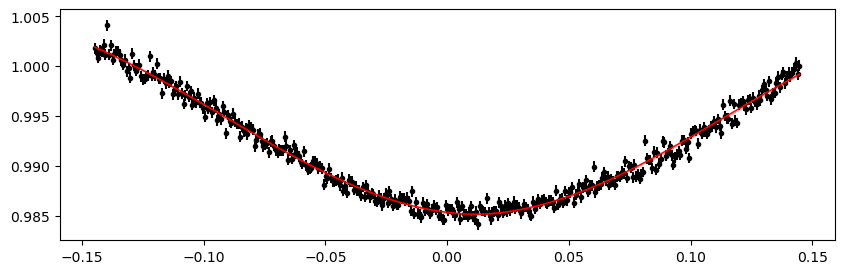

59412.555118000004 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 223.05it/s]


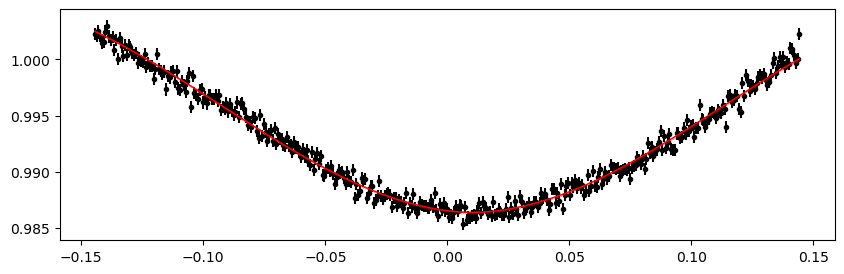

59414.460170000006 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.56it/s]


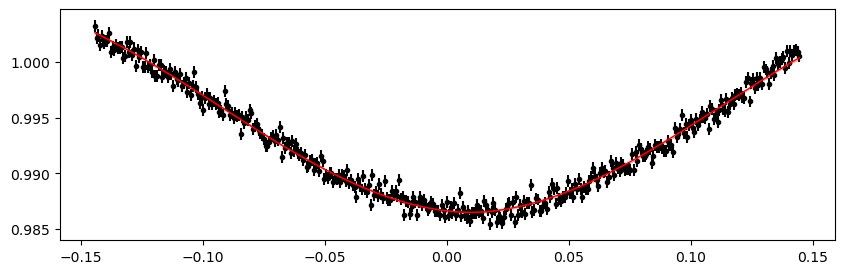

59416.365222 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.45it/s]


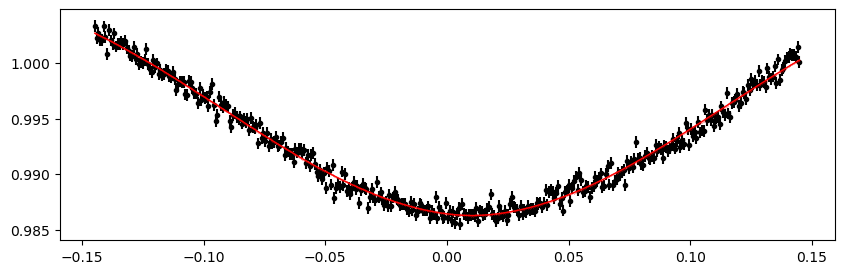

59418.270274 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.14it/s]


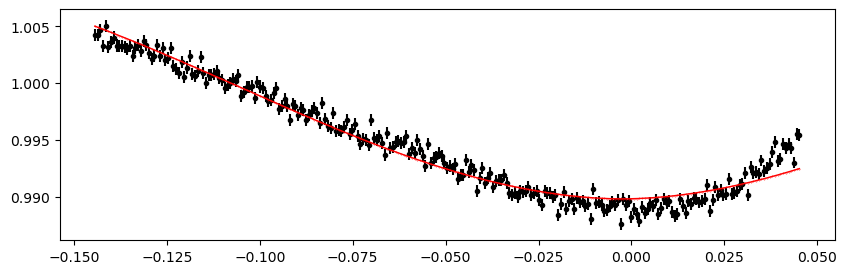

59420.175326000004 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 237.44it/s]


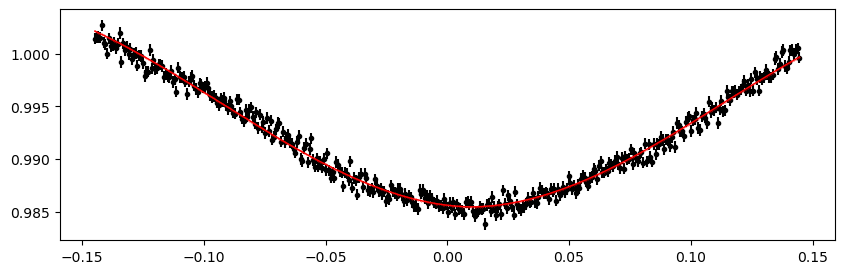

59422.080378000006 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 237.95it/s]


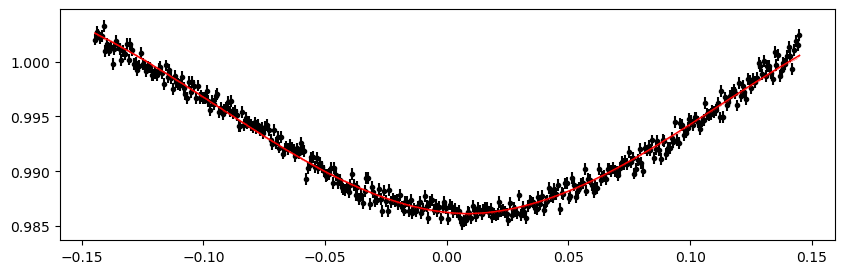

59423.98543 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 240.39it/s]


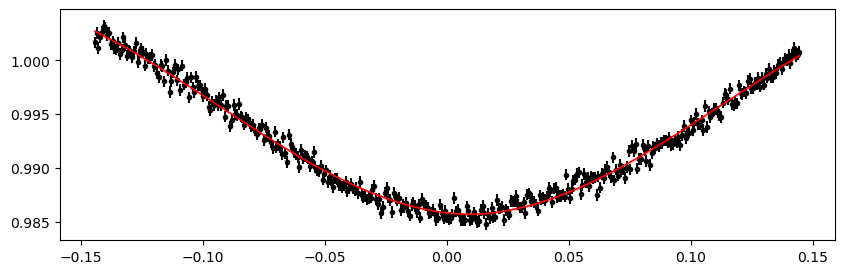

59425.890482 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.92it/s]


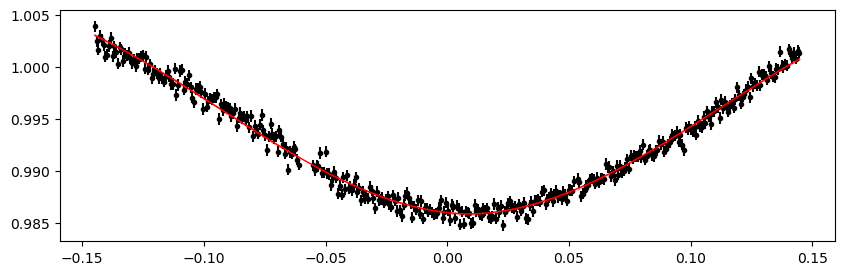

59427.795534000004 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 238.04it/s]


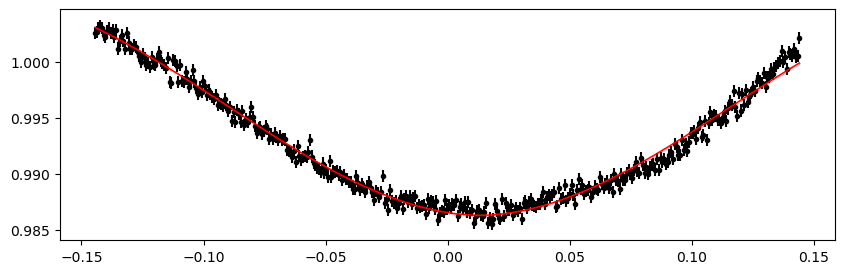

59429.700586000006 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 238.20it/s]


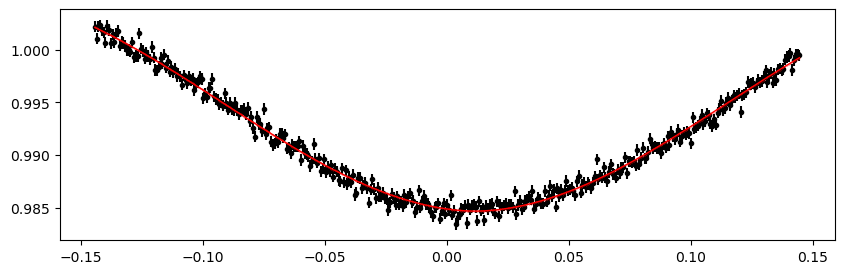

59431.605638 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 235.62it/s]


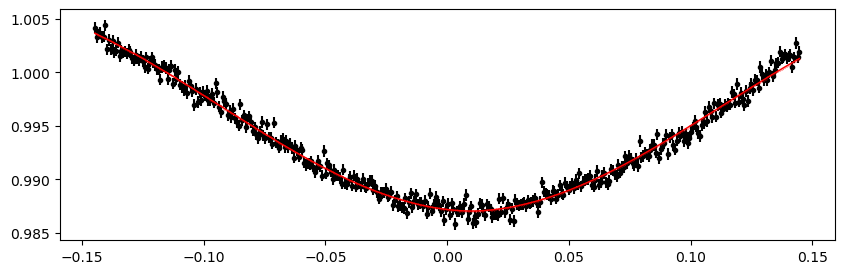

59433.51069 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.43it/s]


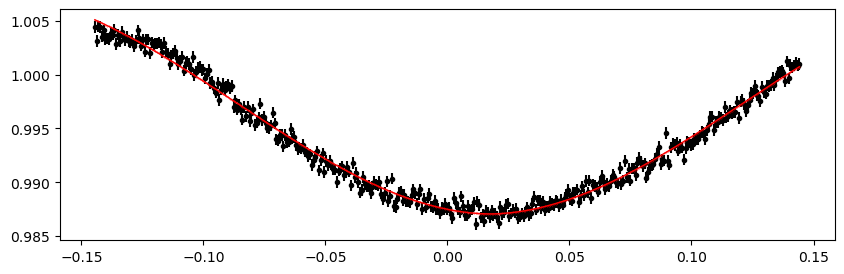

59435.415742000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.77it/s]


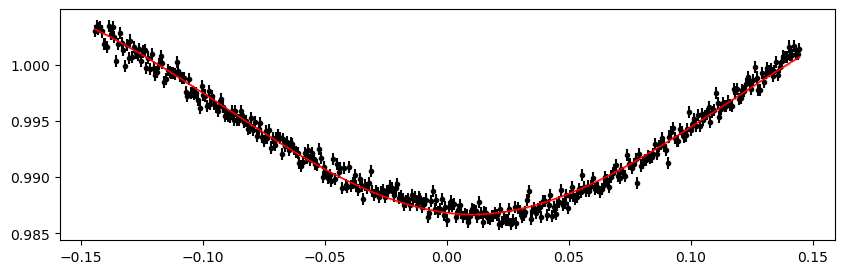

59437.320794 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.94it/s]


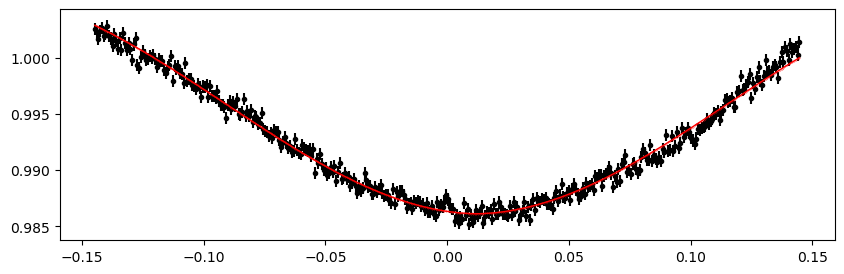

59439.225846 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.89it/s]


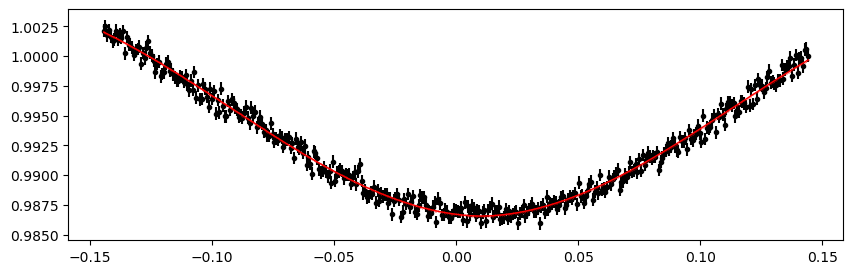

59441.130898 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.48it/s]


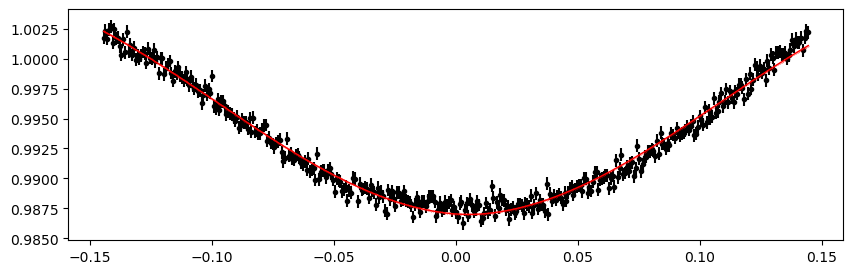

59443.035950000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.65it/s]


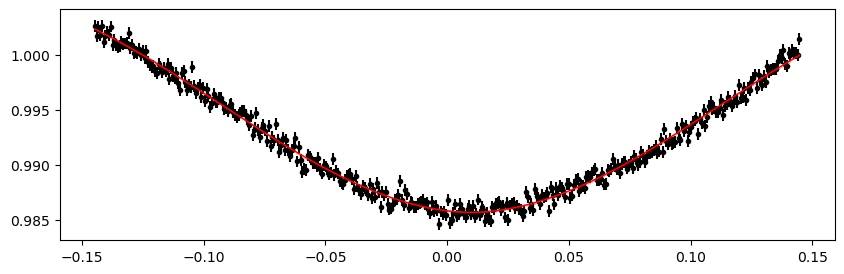

59444.94100200001 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 236.31it/s]


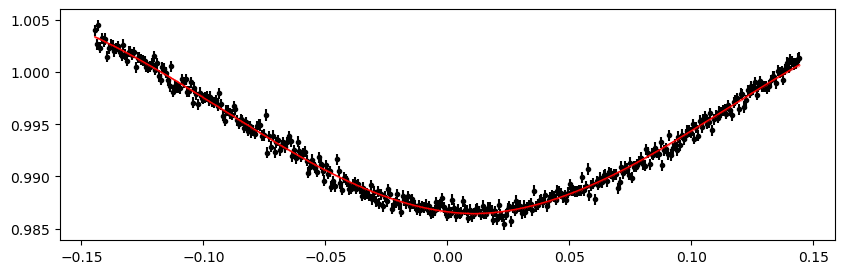

59770.704894 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.30it/s]


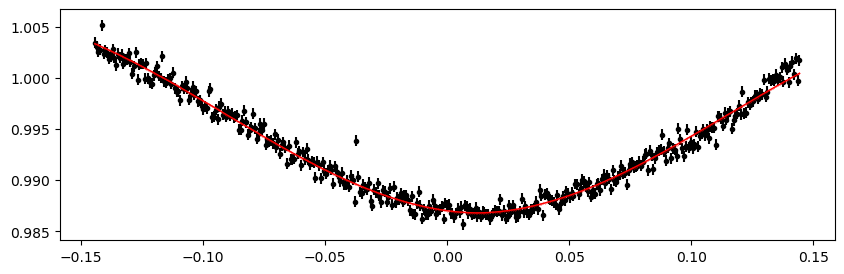

59772.609946000004 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.41it/s]


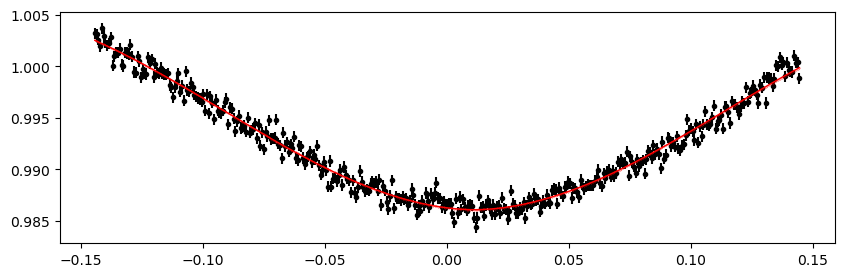

59774.514998000006 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.28it/s]


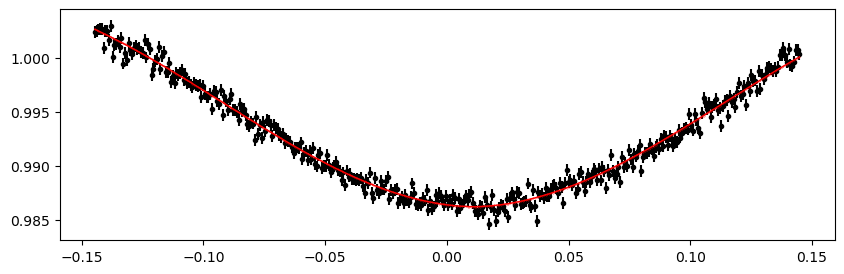

59776.42005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.53it/s]


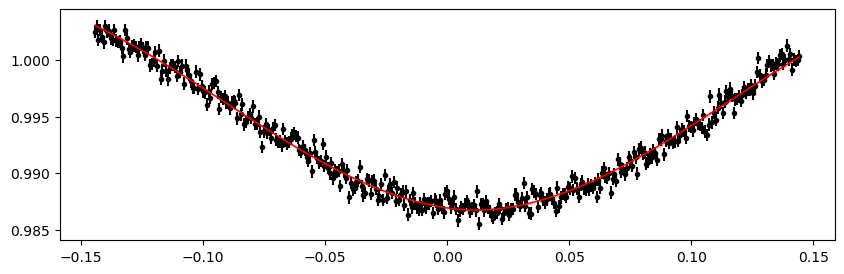

59778.325102 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.36it/s]


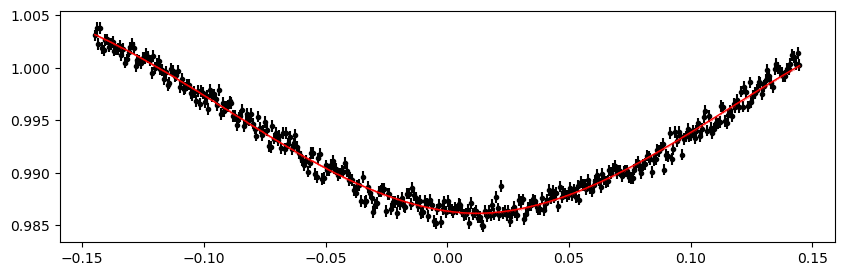

59780.230154000004 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.49it/s]


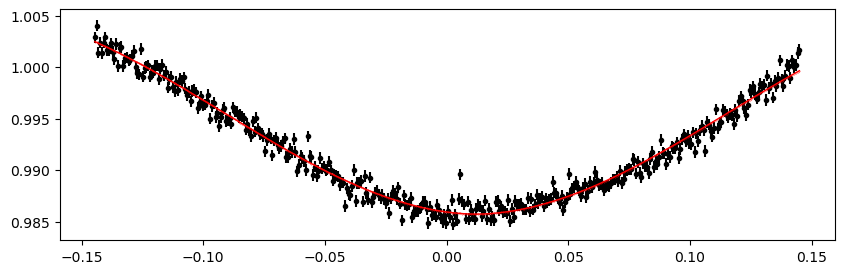

59784.040258 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.16it/s]


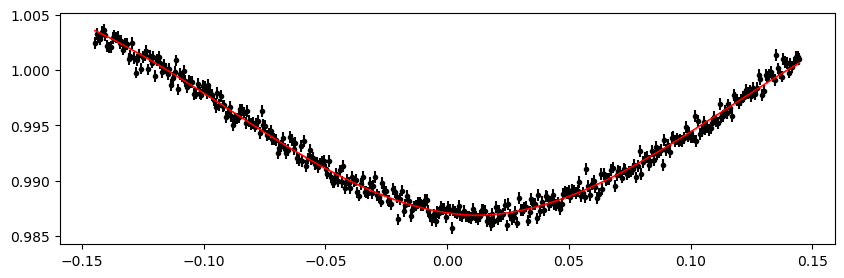

59785.94531 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.34it/s]


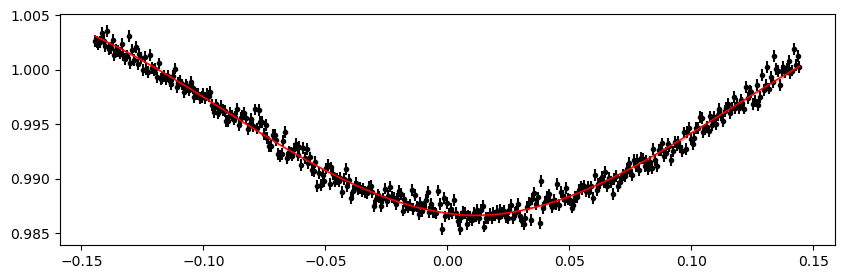

59787.850362000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.89it/s]


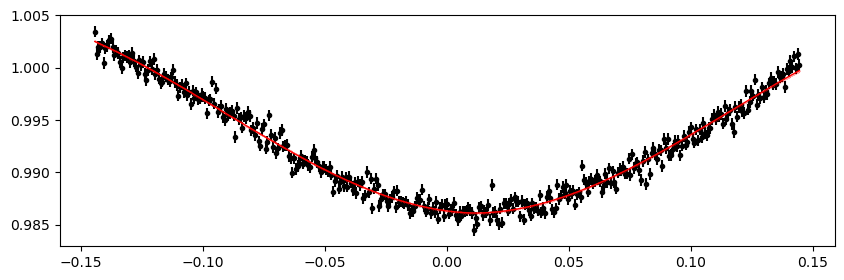

59789.755414 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.69it/s]


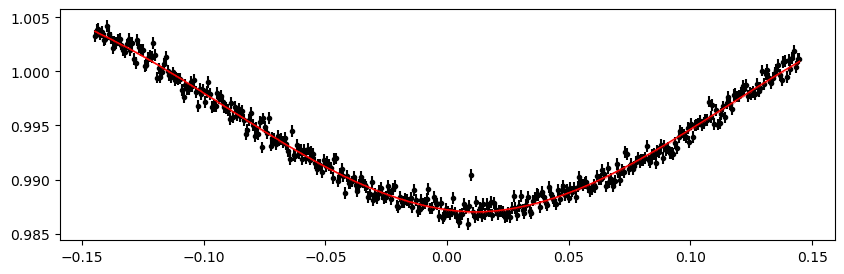

59791.660466 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.44it/s]


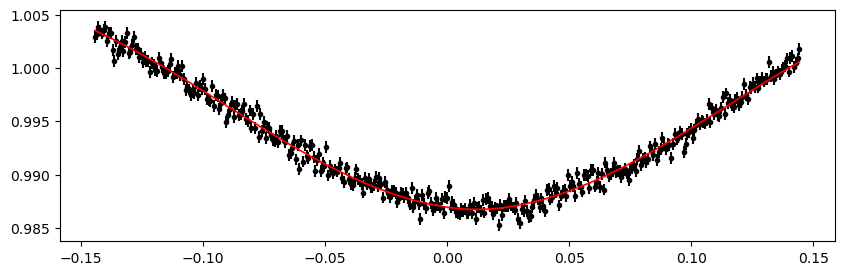

59793.565518 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.57it/s]


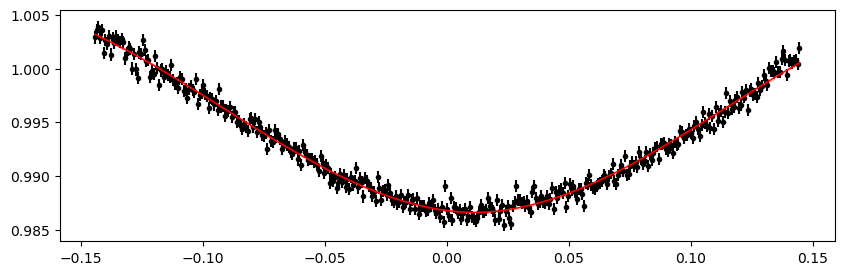

59795.470570000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 278.47it/s]


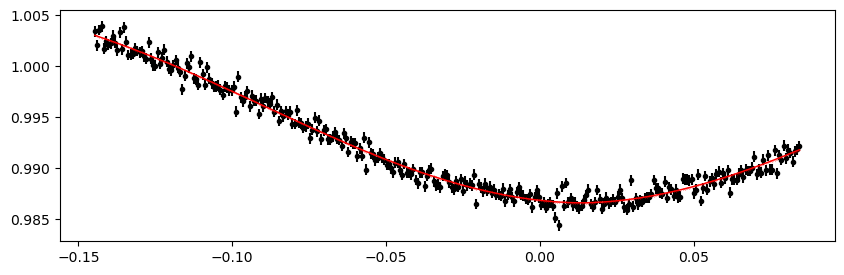

59797.37562200001 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.31it/s]


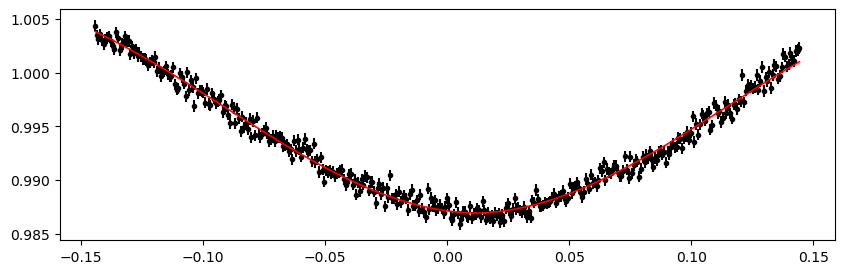

59799.280674 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.98it/s]


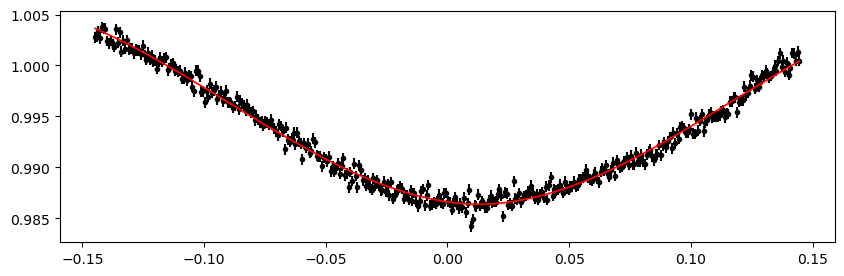

59801.185726 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.65it/s]


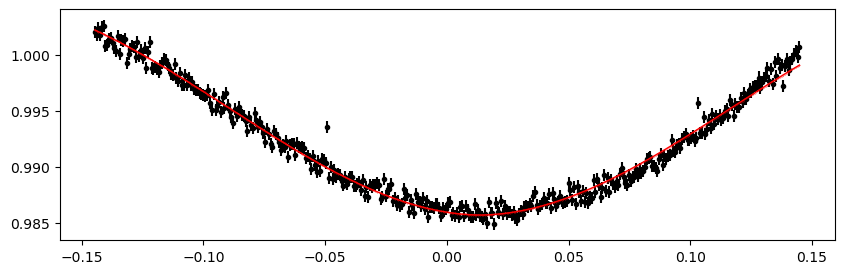

59803.090778000005 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.84it/s]


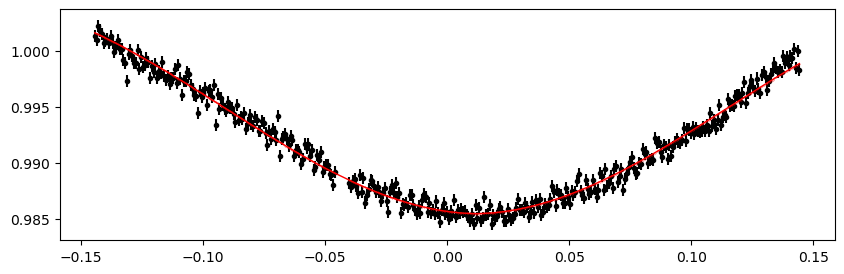

59804.99583 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 232.85it/s]


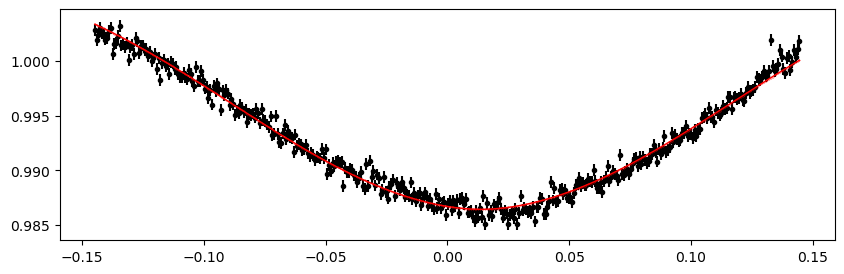

59806.900882 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.23it/s]


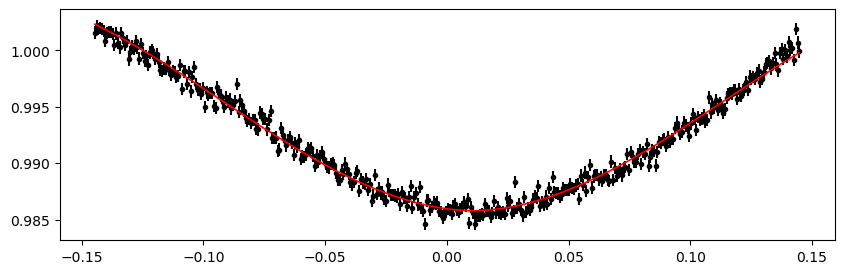

59808.805934 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.09it/s]


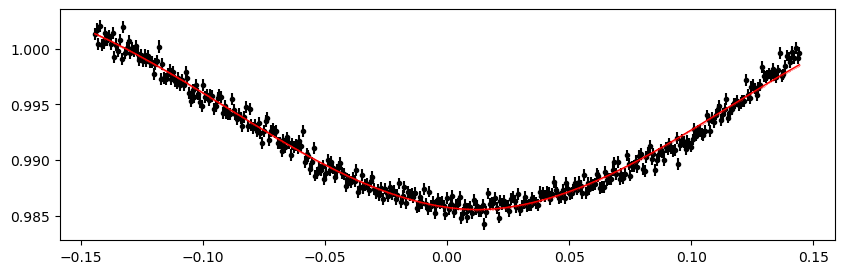

59810.710986000006 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 256.06it/s]


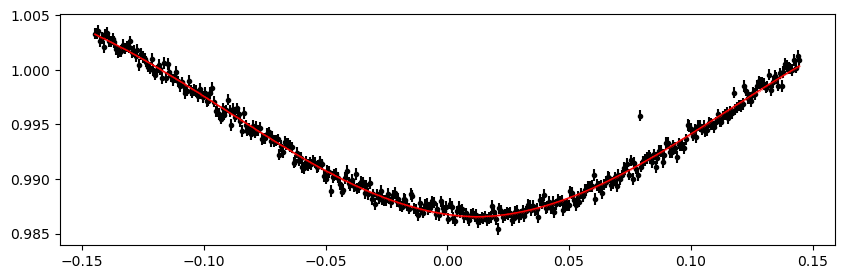

59812.616038 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.59it/s]


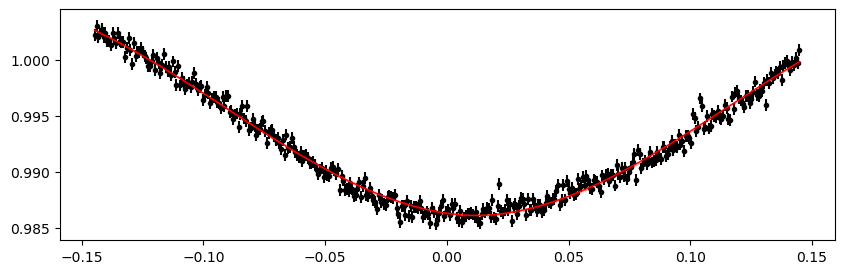

59814.52109 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.72it/s]


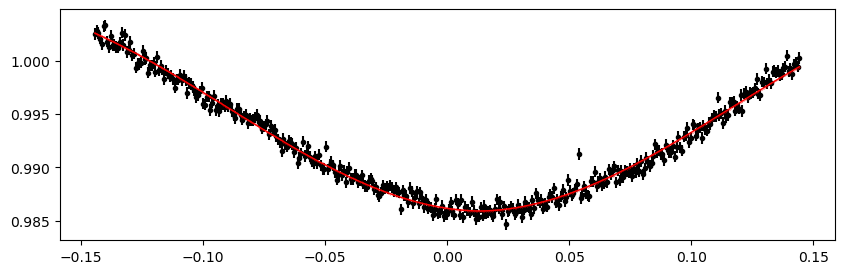

59816.426142000004 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 256.10it/s]


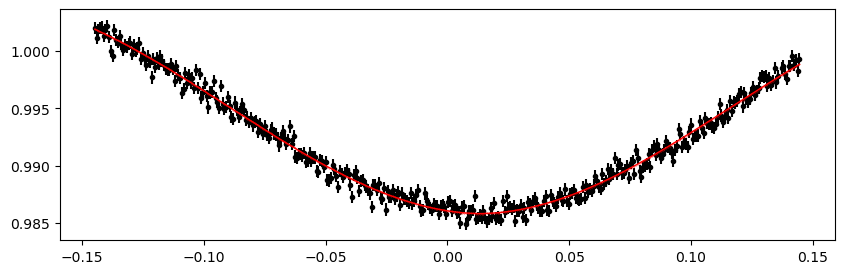

59818.331194000006 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.41it/s]


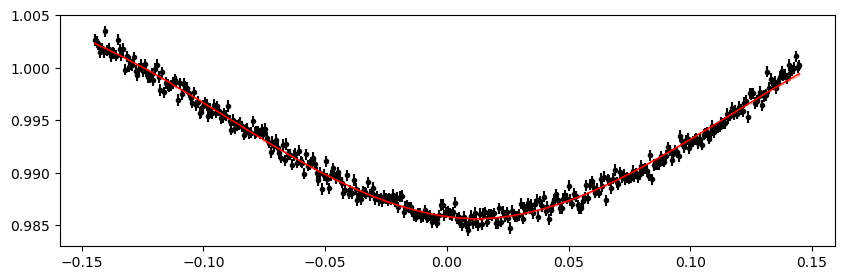

59820.236246 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.93it/s]


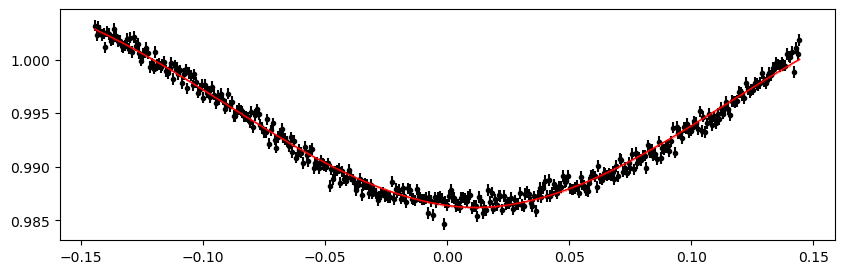

59822.141298 1.0079770953810983 -0.021266856349716978 0.1679917286817513


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.48it/s]


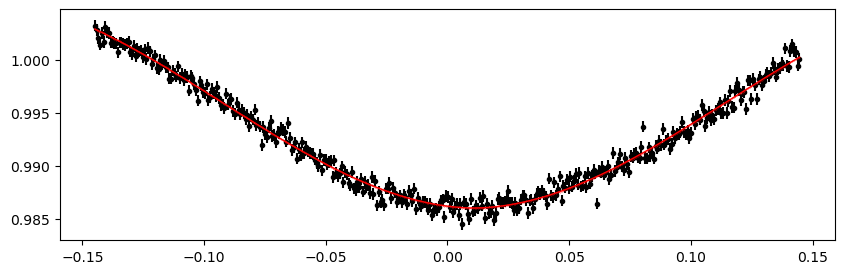

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has already been completed -- skip
Number 20 has

100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.19it/s]


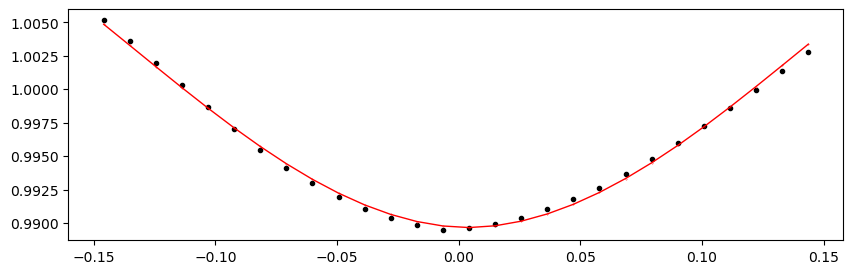

58683.927974508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.36it/s]


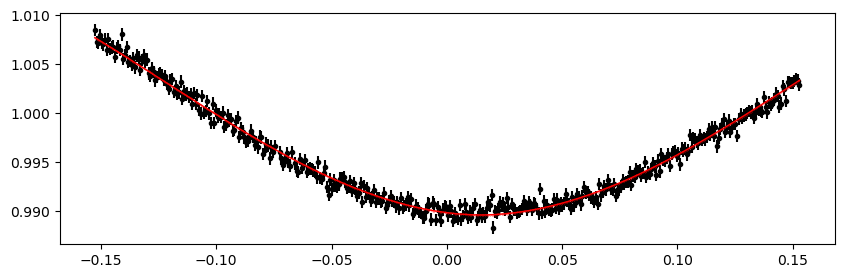

58685.833026508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.42it/s]


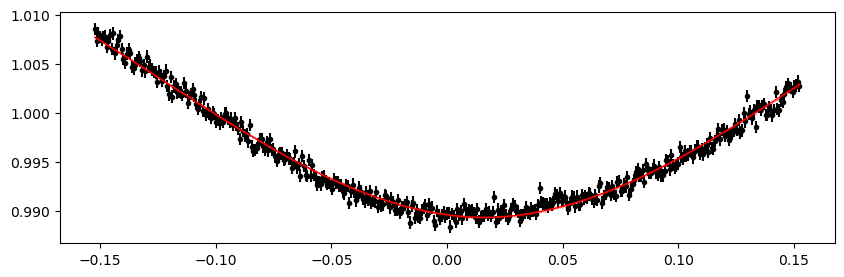

58687.738078507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.06it/s]


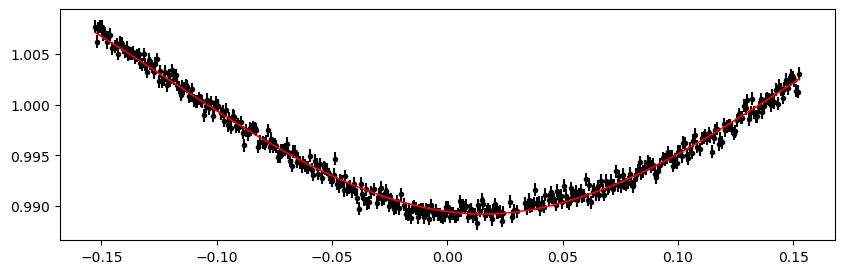

58689.643130508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.93it/s]


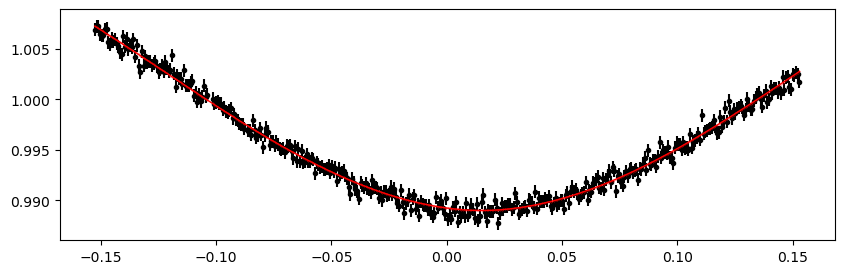

58691.548182508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.75it/s]


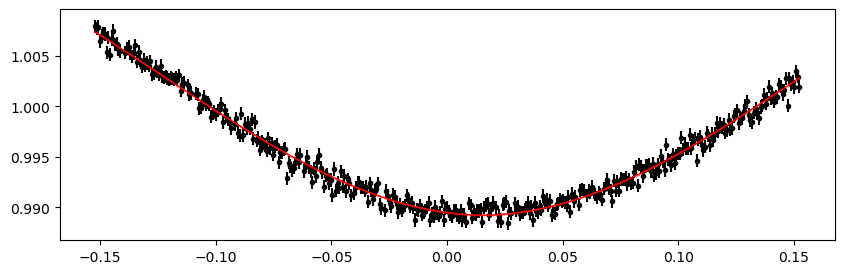

58693.453234508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.91it/s]


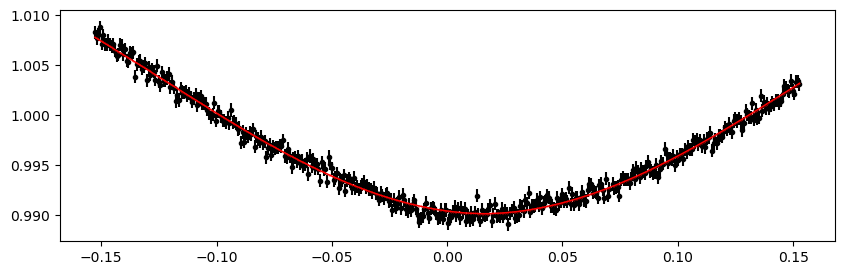

58695.358286507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.57it/s]


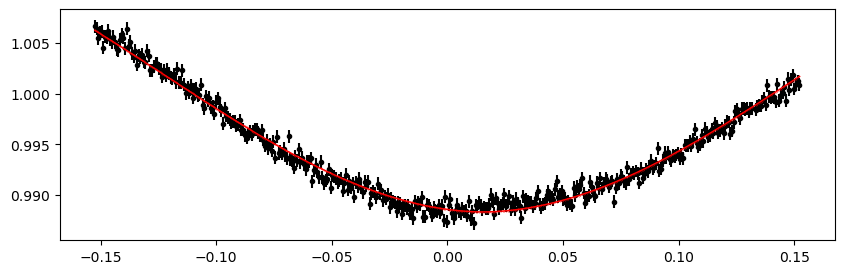

58697.263338508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 237.24it/s]


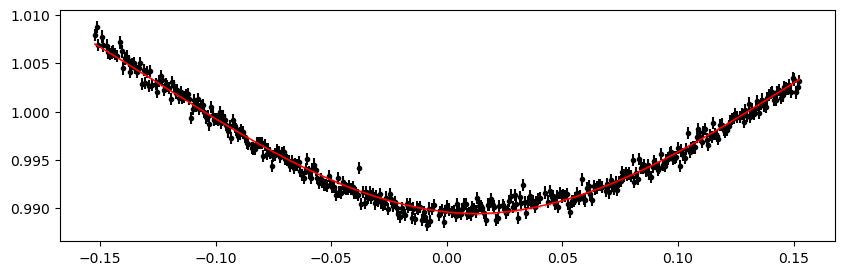

58699.168390508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.49it/s]


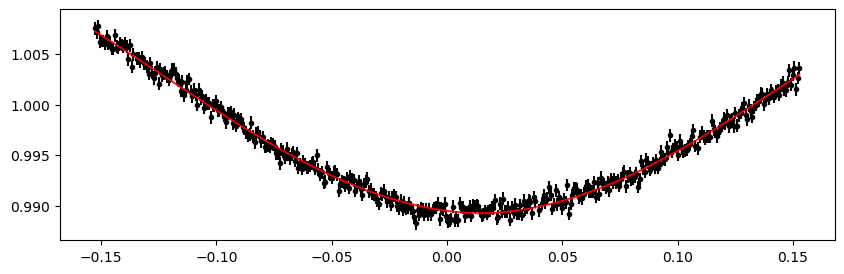

58701.073442508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.12it/s]


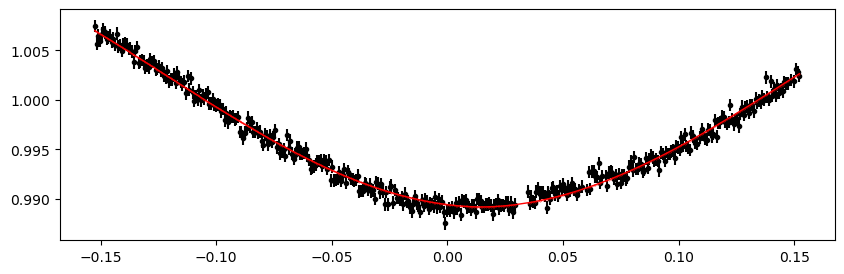

58702.978494507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.29it/s]


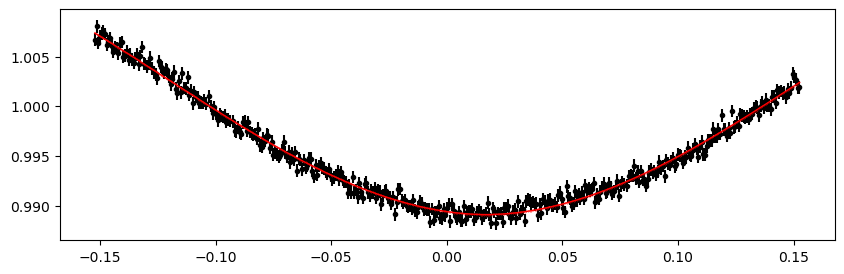

58704.883546508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.26it/s]


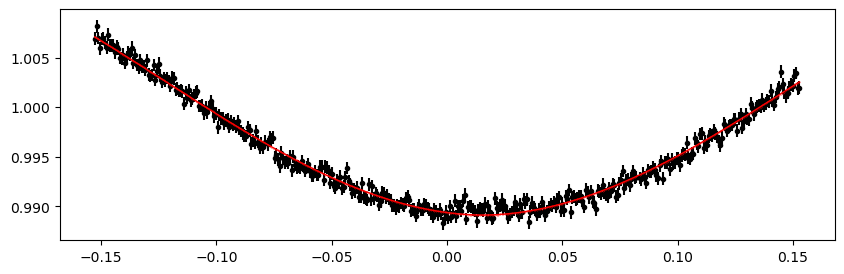

58706.788598508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.25it/s]


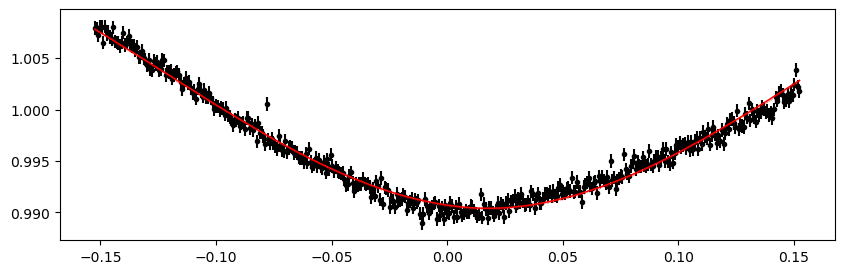

58708.693650508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.70it/s]


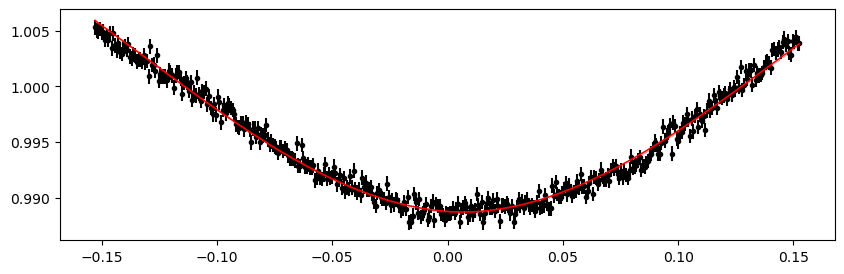

59390.702266508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.56it/s]


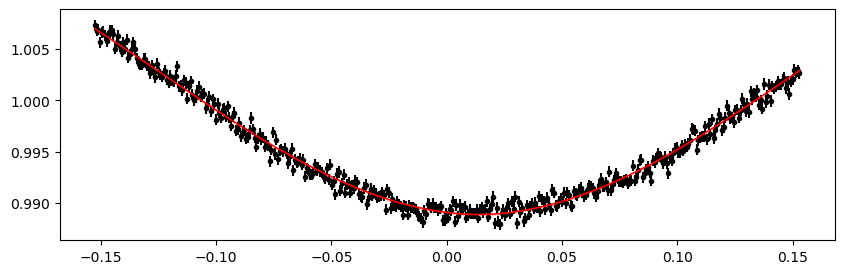

59392.607318508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 232.79it/s]


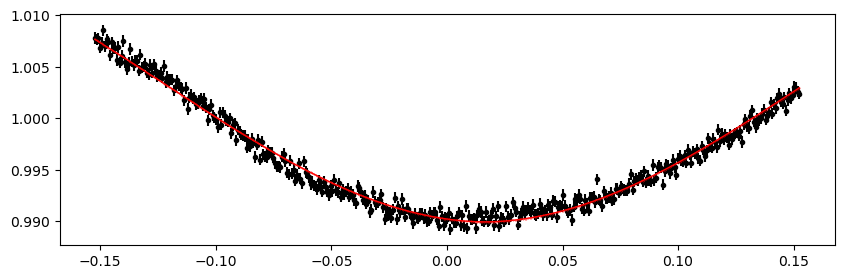

59394.512370508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.49it/s]


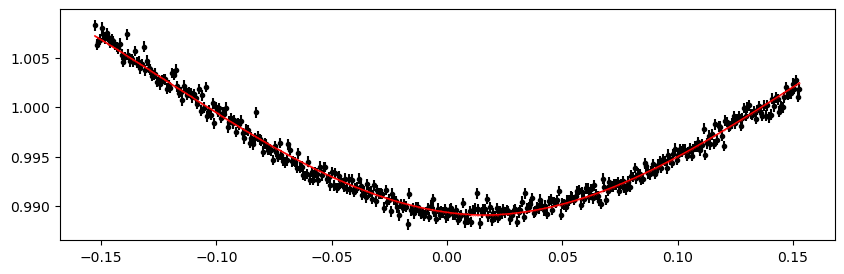

59396.417422508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.84it/s]


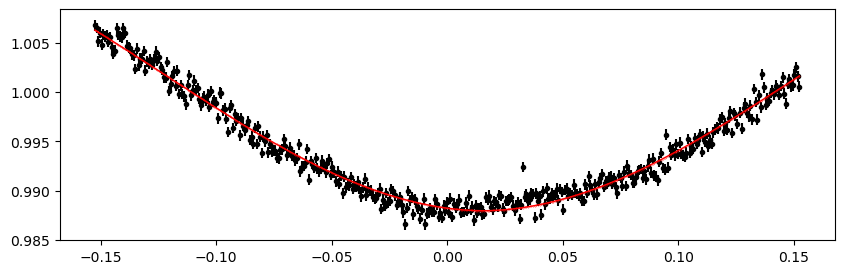

59398.322474508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.90it/s]


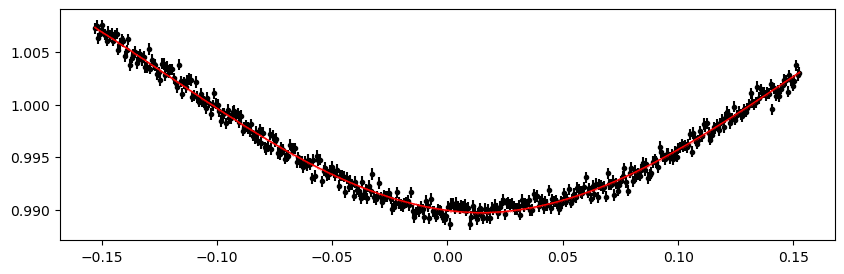

59400.227526507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.43it/s]


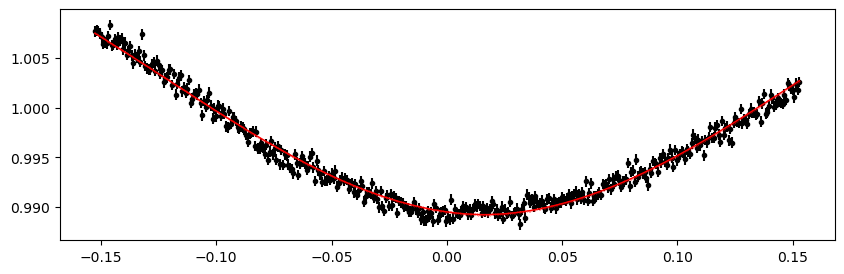

59402.132578508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 245.21it/s]


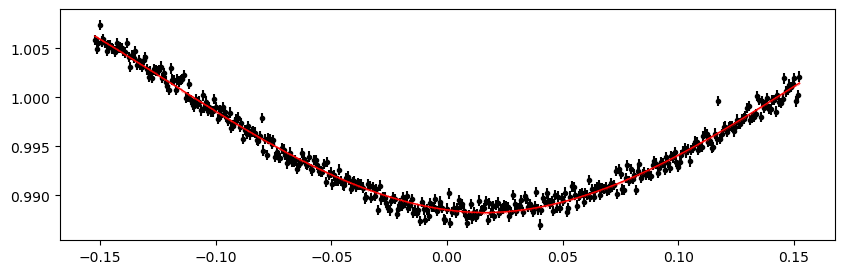

59404.037630508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.60it/s]


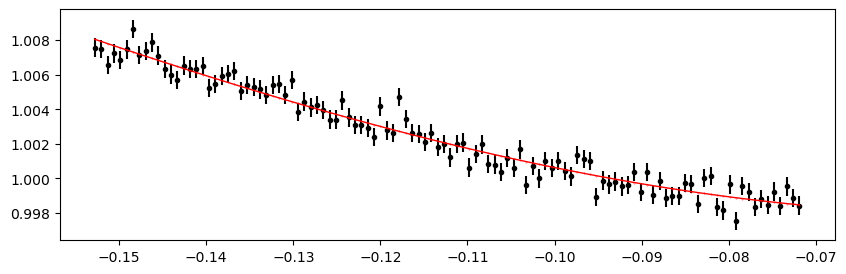

59405.942682508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 233.56it/s]


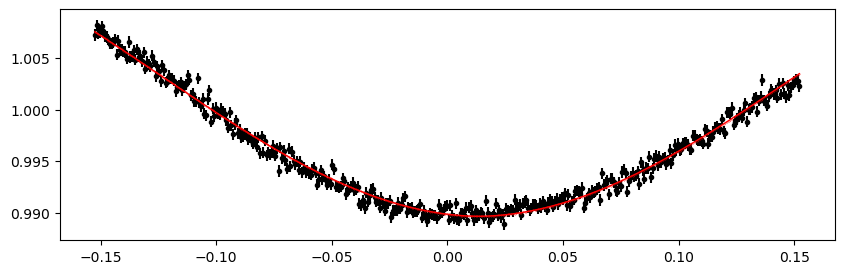

59407.847734507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.60it/s]


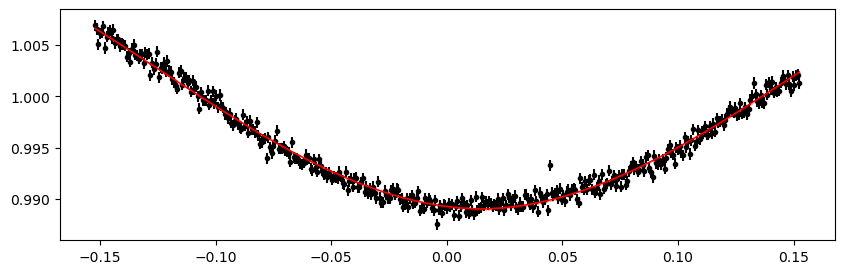

59409.752786508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.39it/s]


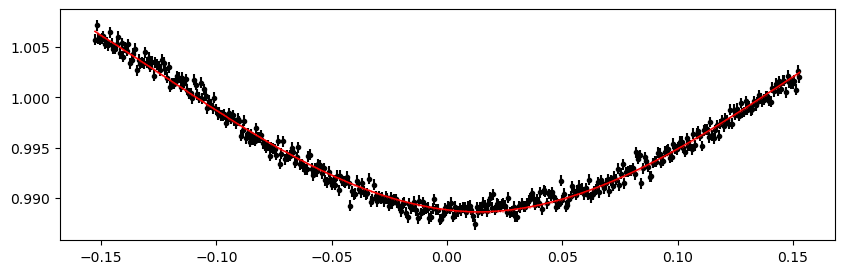

59411.657838508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.21it/s]


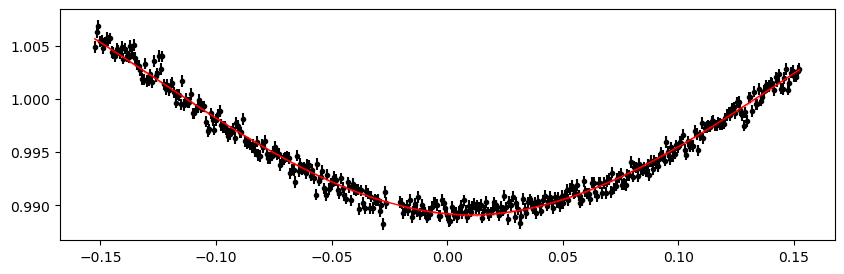

59413.562890508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.47it/s]


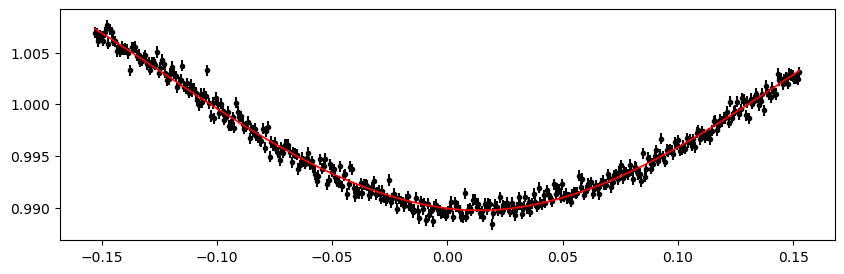

59415.467942507996 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.63it/s]


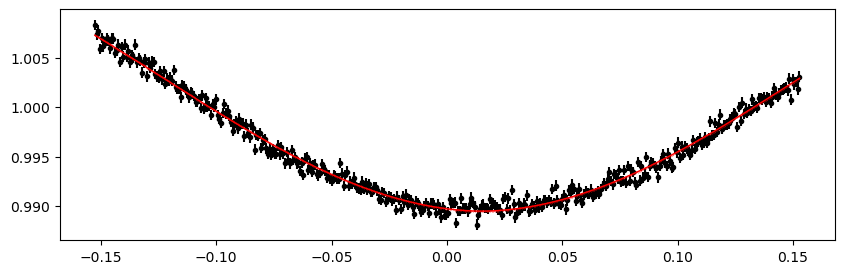

59417.372994508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.68it/s]


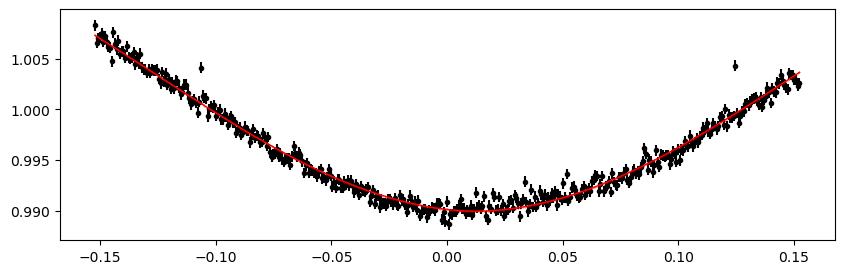

59419.278046508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.28it/s]


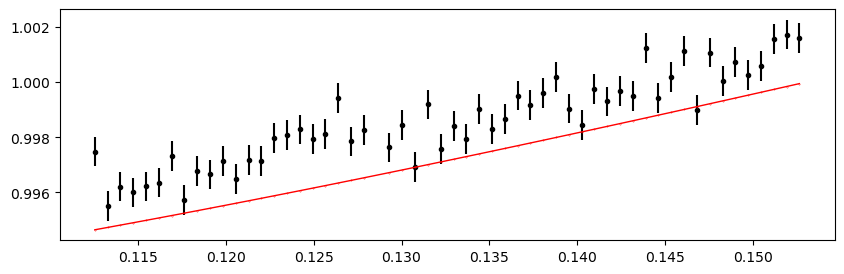

59421.183098508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.74it/s]


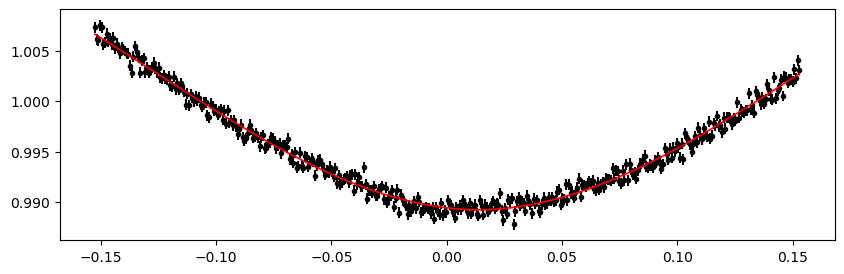

59423.088150507996 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.66it/s]


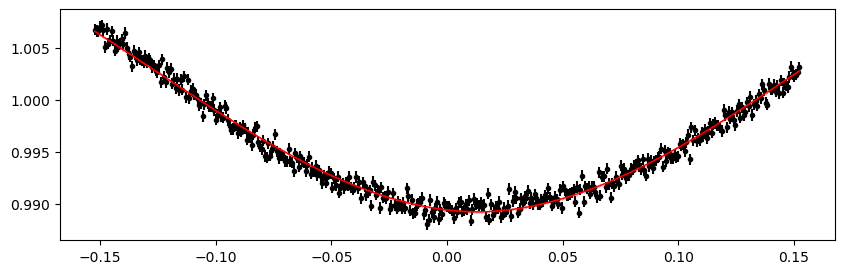

59424.993202508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.87it/s]


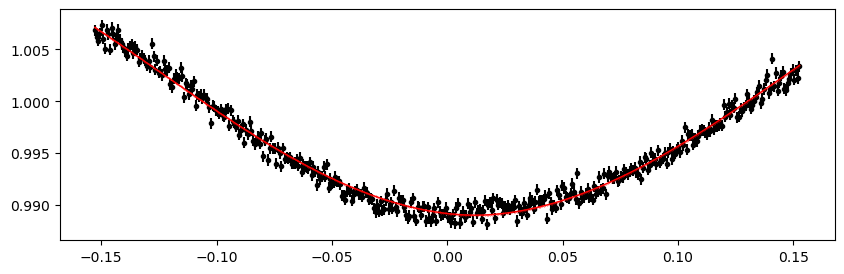

59426.898254508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.70it/s]


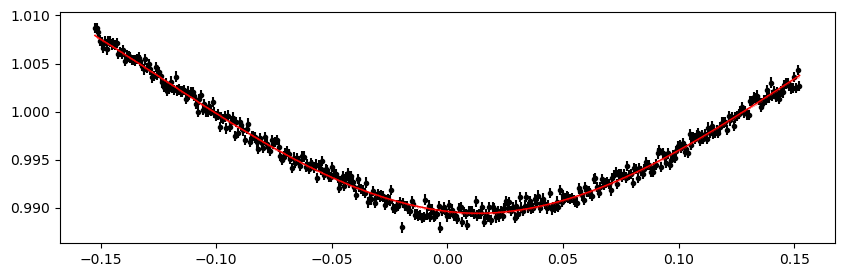

59428.803306507994 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 235.31it/s]


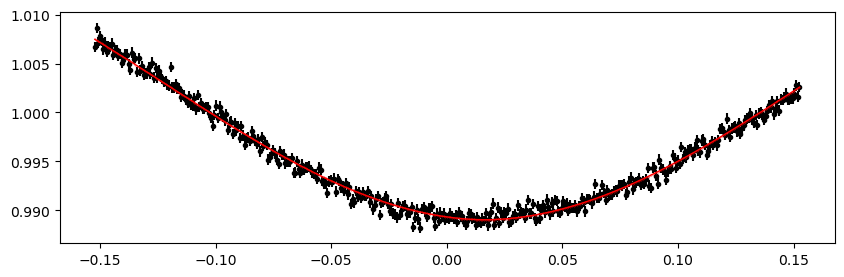

59430.708358507996 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.74it/s]


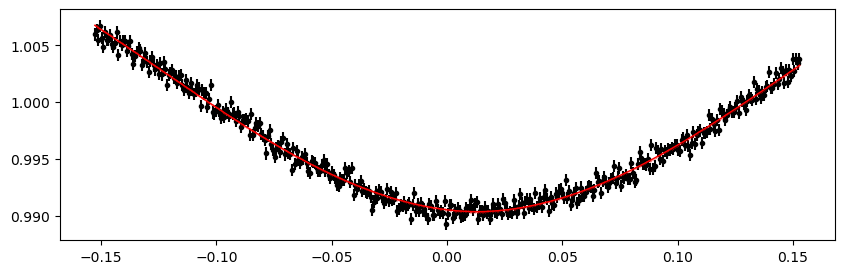

59434.518462508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.40it/s]


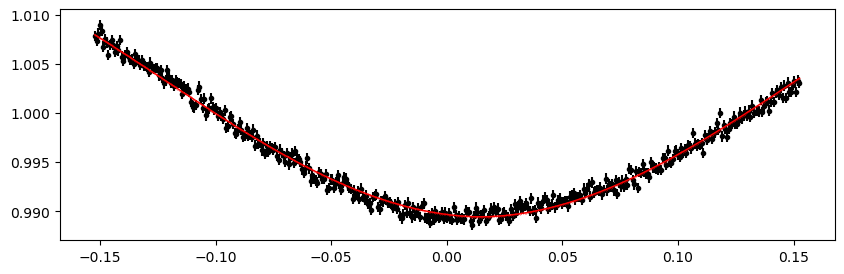

59436.423514508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.99it/s]


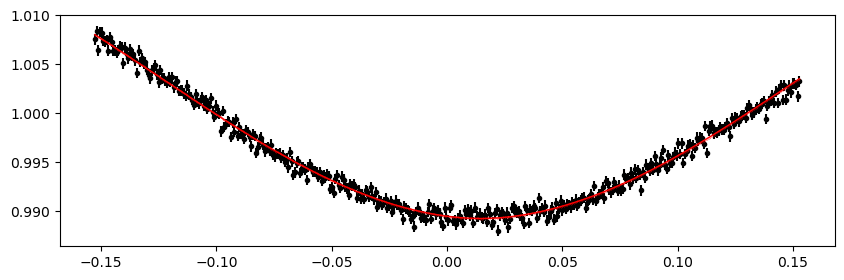

59438.328566508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.78it/s]


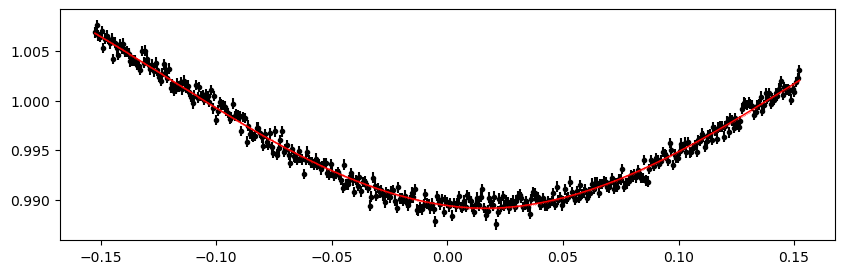

59440.233618508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.05it/s]


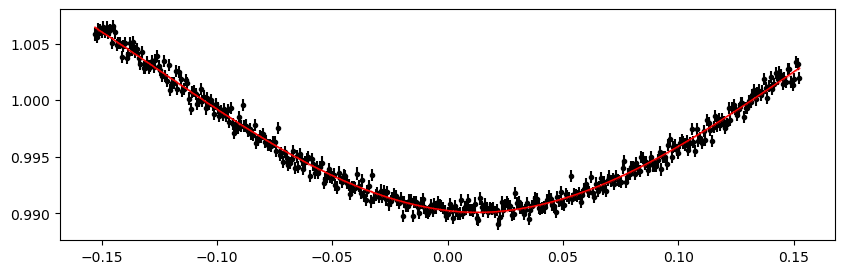

59442.138670508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 232.32it/s]


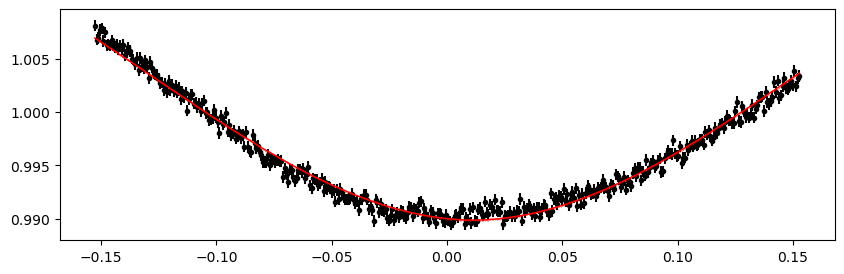

59444.043722507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 231.87it/s]


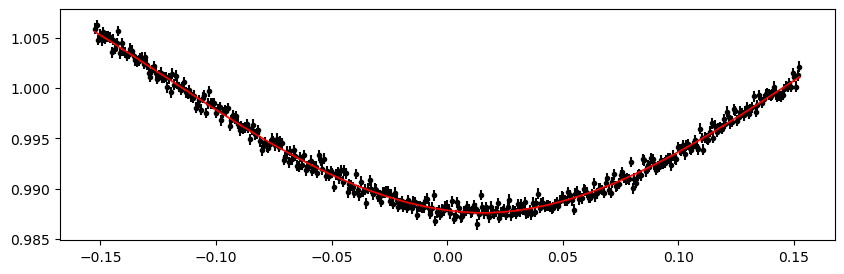

59445.948774508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 278.53it/s]


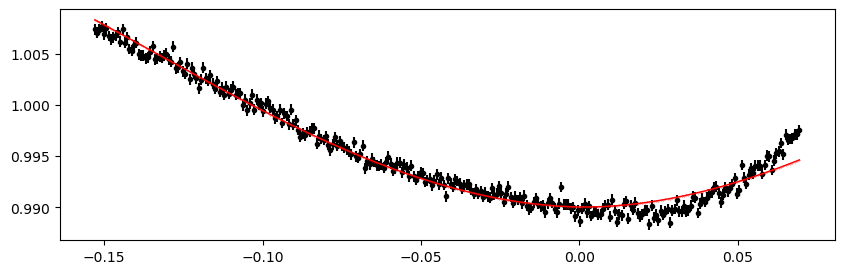

59769.807614508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.49it/s]


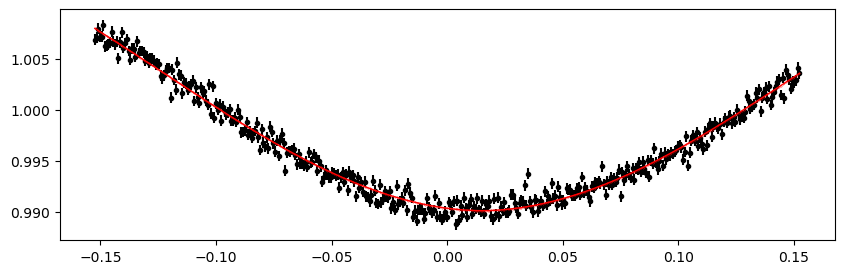

59771.712666508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.34it/s]


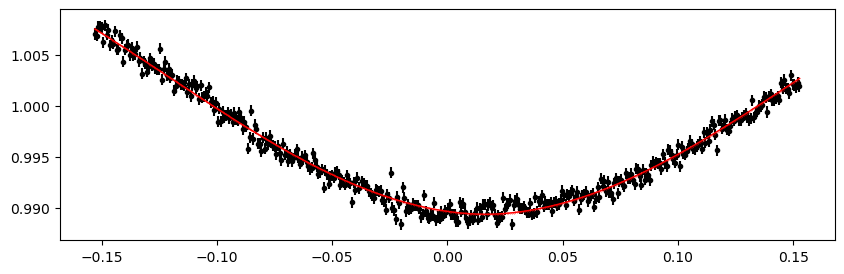

59773.617718508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.27it/s]


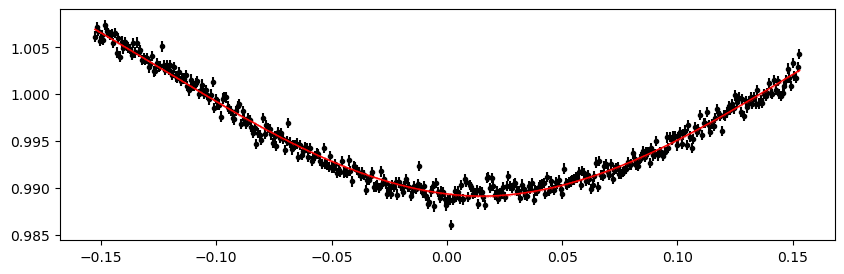

59775.522770507996 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.18it/s]


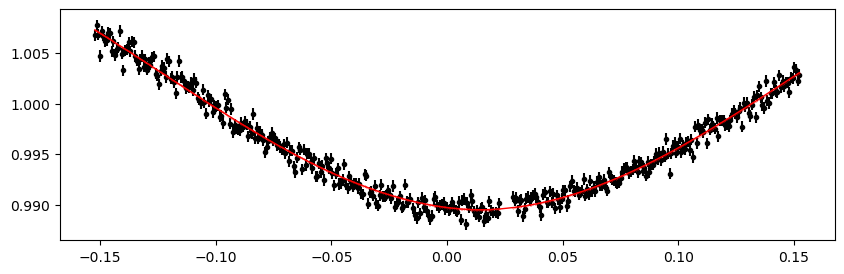

59777.427822508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.25it/s]


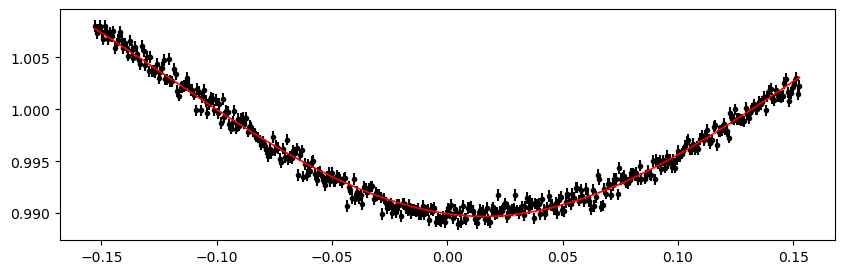

59779.332874508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 245.00it/s]


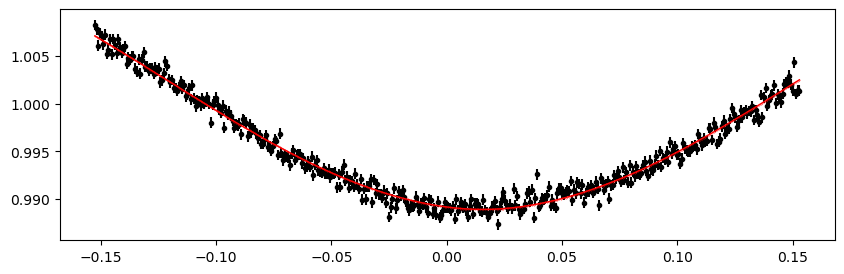

59781.237926507994 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.27it/s]


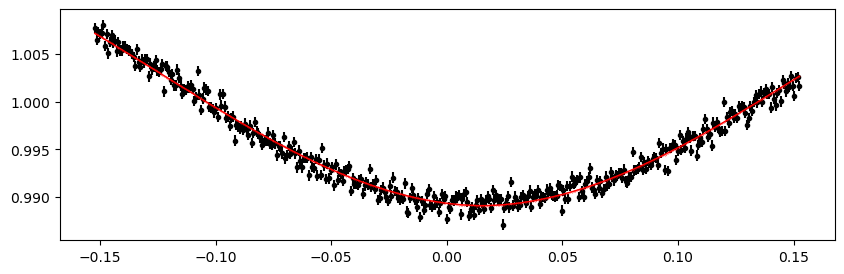

59783.142978507996 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 285.33it/s]


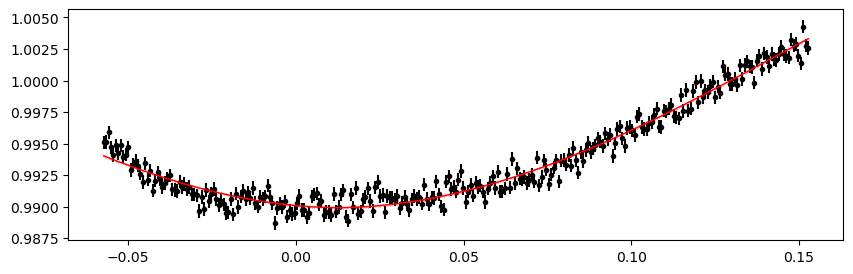

59785.048030508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.13it/s]


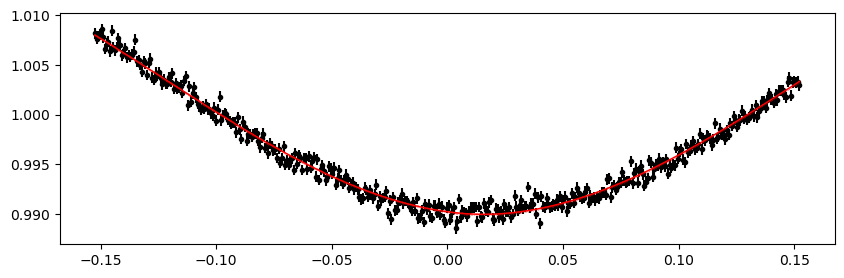

59786.953082508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.01it/s]


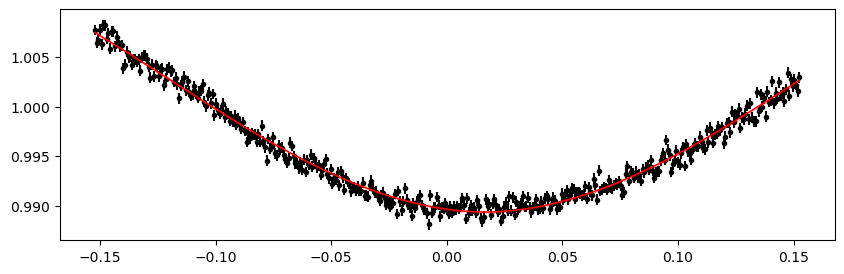

59788.858134508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.58it/s]


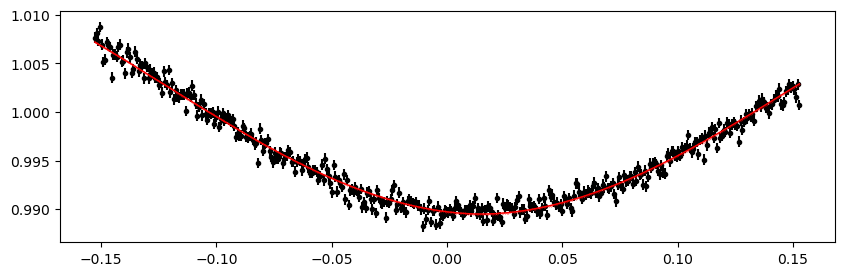

59790.763186508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.20it/s]


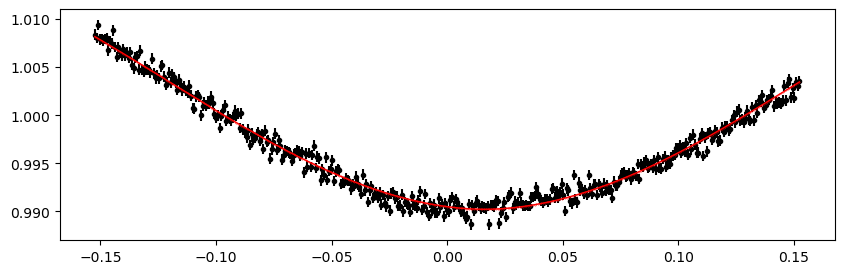

59792.668238508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.29it/s]


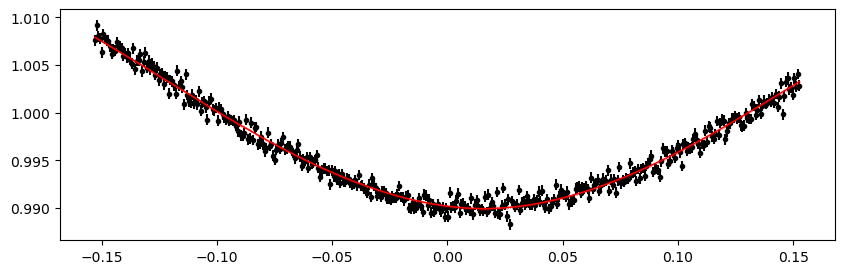

59794.573290508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.73it/s]


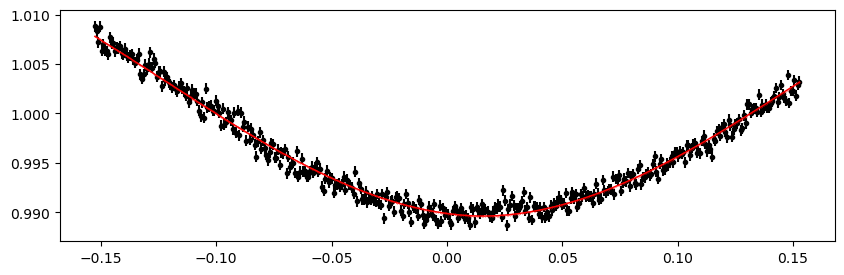

59796.478342507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.78it/s]


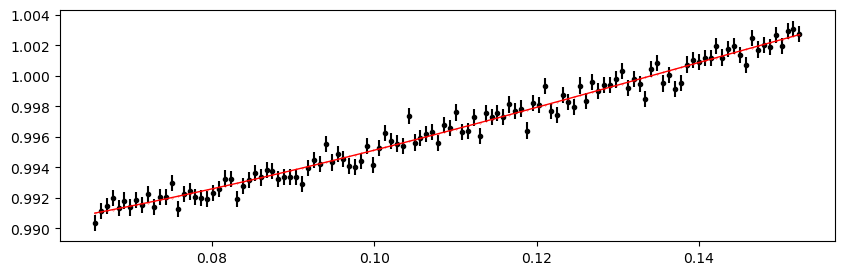

59798.383394508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.00it/s]


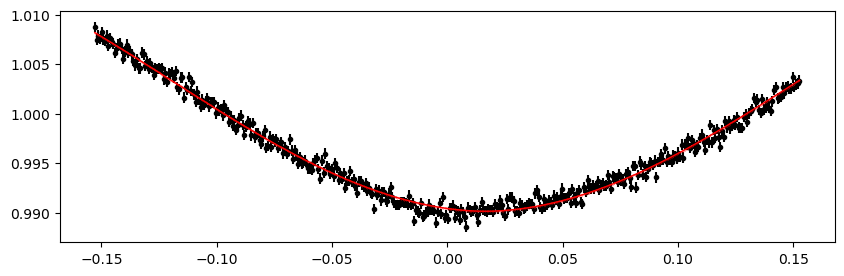

59800.288446508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 232.45it/s]


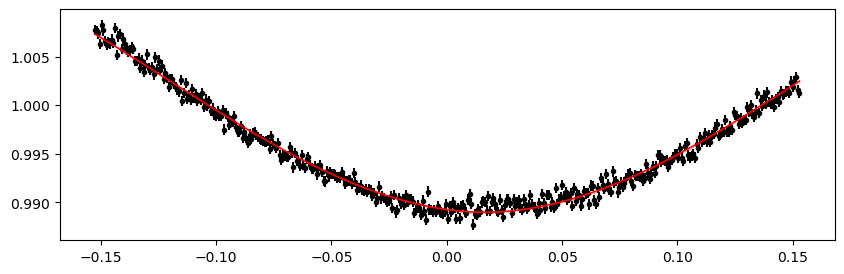

59802.193498508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 229.68it/s]


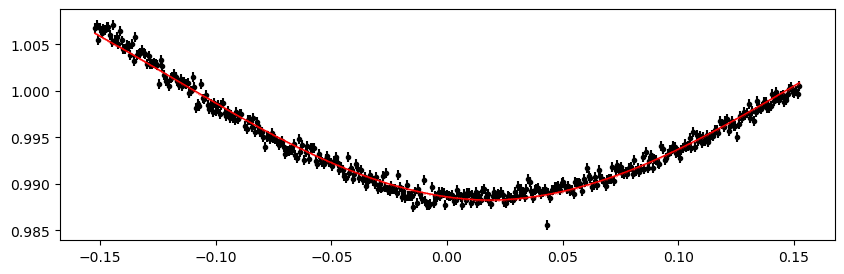

59804.098550507995 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.95it/s]


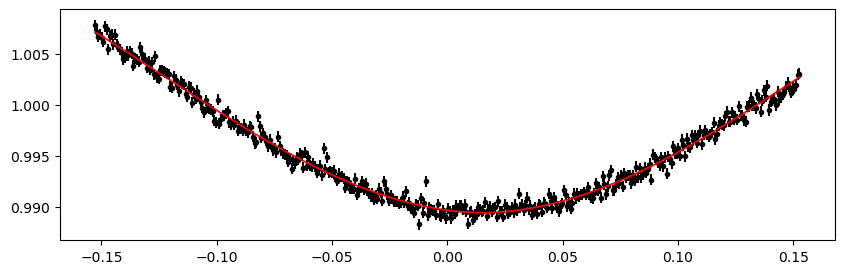

59806.003602508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 252.02it/s]


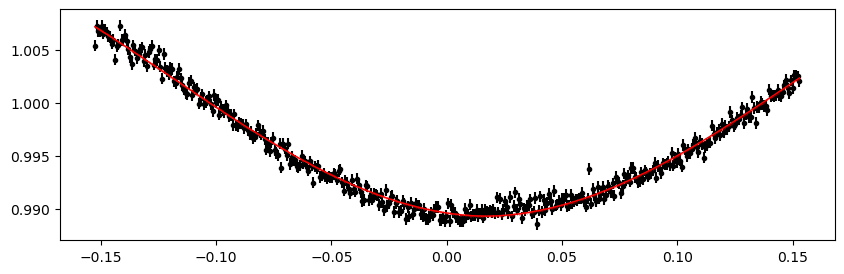

59807.908654508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.67it/s]


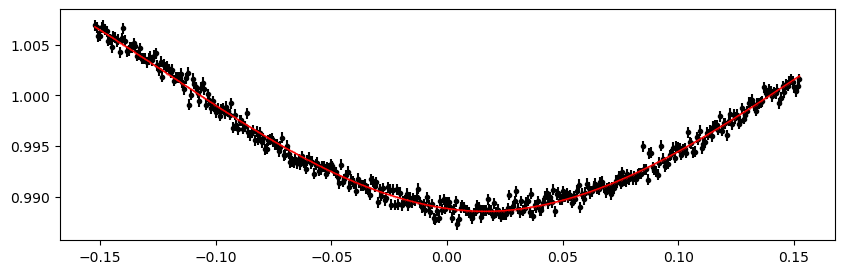

59811.718758507996 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.56it/s]


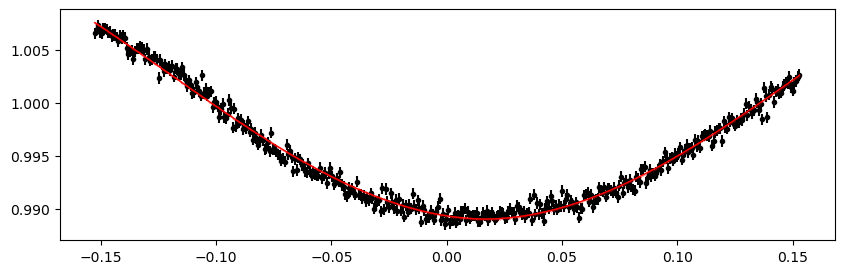

59813.623810508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 232.19it/s]


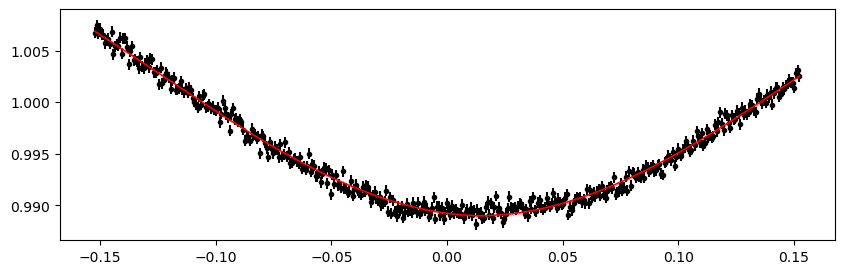

59815.528862508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 229.52it/s]


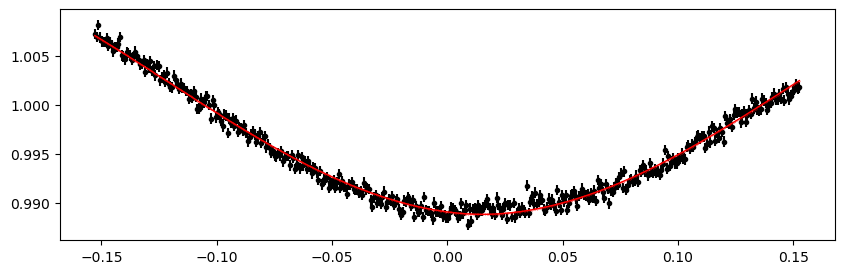

59817.433914508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.02it/s]


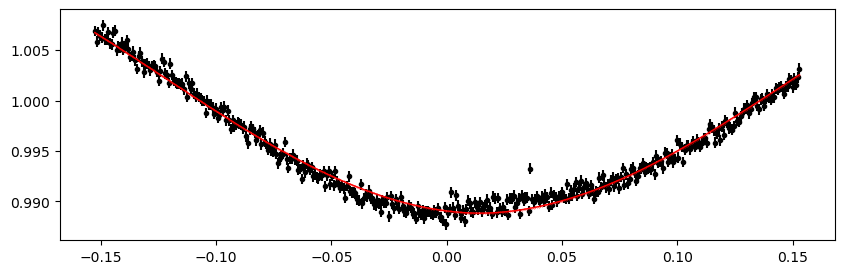

59819.338966507996 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.19it/s]


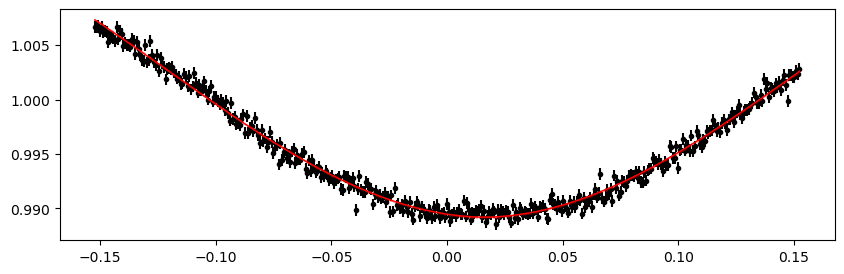

59821.244018508 1.017958545579376 -0.02877616684866633 -0.30112563808942394


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.10it/s]


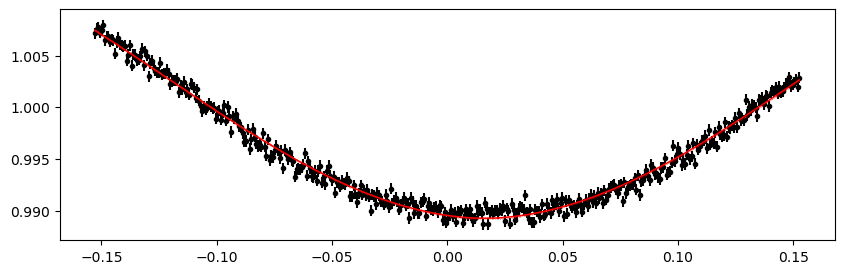

In [114]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# -----

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

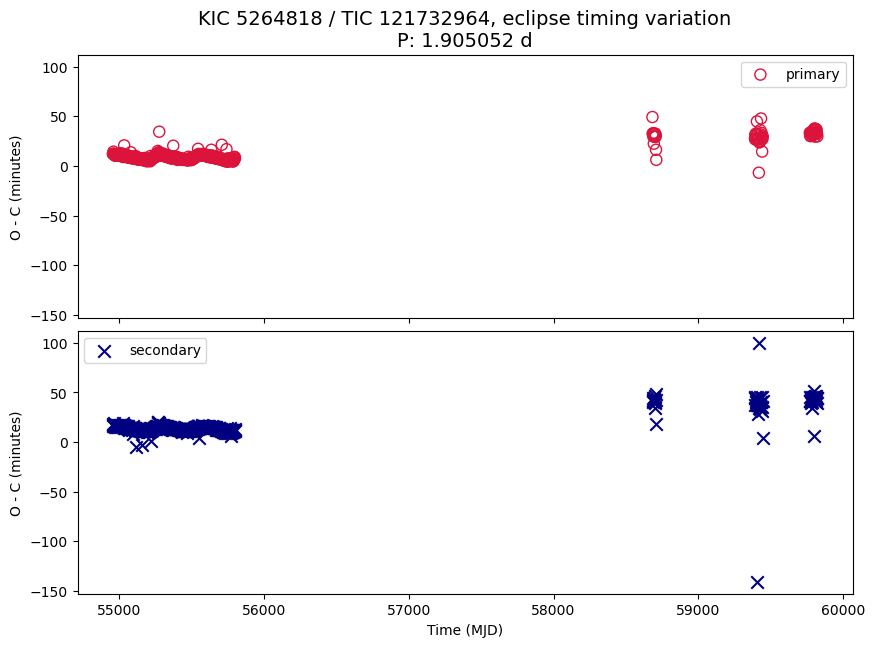

In [117]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True, sharey=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### O-C Plot, Zoom In

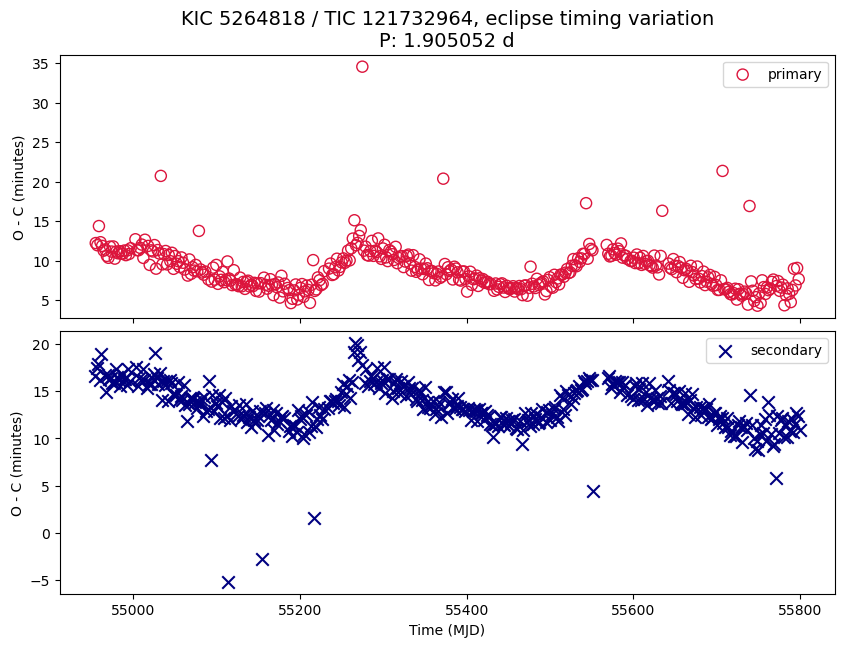

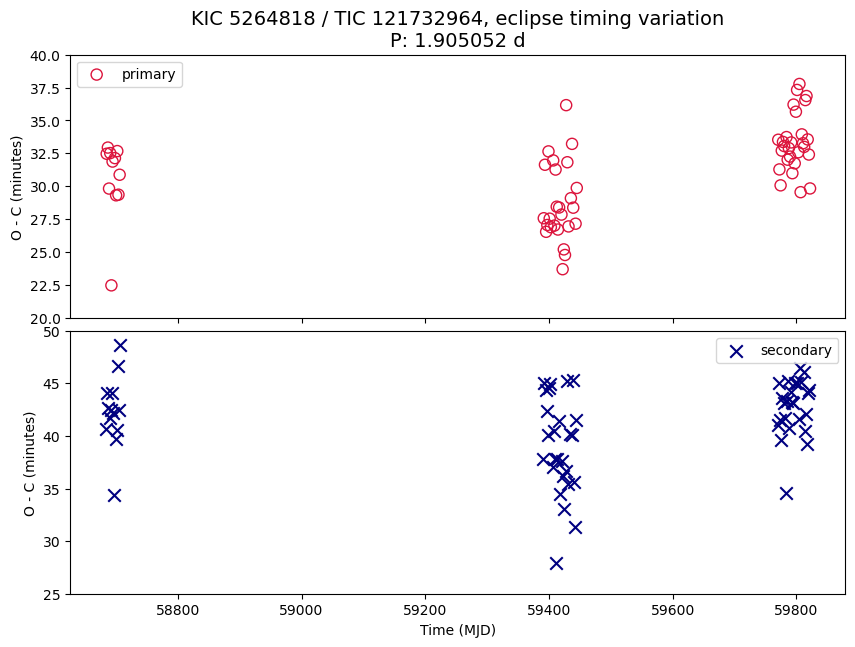

In [130]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] < 55800]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] < 55800]


    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

# ---

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] > 58000]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] > 58000]
    # in_df_secondary = in_df_secondary[in_df_secondary['shift_mins'] < 10]  # exclude a single outlier

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

# exclude some outliers
axs[0].set_ylim(20, 40)
axs[1].set_ylim(25, 50)

plt.subplots_adjust(hspace=0.05)
plt.show()


## make a periodogram 

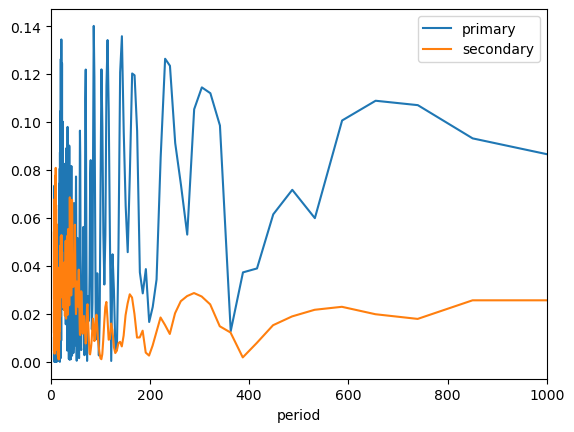

In [131]:
# TESS data roughly has a peak of ~500 days. The period found in Kepler data.
# it's understandably nosier

frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower(minimum_frequency=1 / 1000)  # ensure the max period exceeds ~500 d in the paper

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower(minimum_frequency=1 / 1000)
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


## Results Summary

In [132]:
# FILL-IN the ETV results / comments
has_etv = "Practice"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "Reproducing Kepler ETV in 2013ApJ works for both primary and secondary eclipises in Kepler data, inconclusive for TESS data (using the Kepler's model params)"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),  # counting TESS only
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                            121732964
has_etv                                                                                                                         Practice
comments     Reproducing Kepler ETV in 2013ApJ works for both primary and secondary eclipises in Kepler data, inconclusive for TESS data
period                                                                                                                          1.905052
depth_pct_p                                                                                                                         2.13
depth_pct_s                                                                                                                         2.88
epoch_p                                                                                                                     54954.733438
epoch_s                                                                                                                     54953.836159
num_sectors                                                                                                                            5
time_span                                                                                                                        4870.73
time_start                                                                                                                      54953.04
time_end                                                                                                                        59823.77


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
121732964,Practice,"Reproducing Kepler ETV in 2013ApJ works for both primary and secondary eclipises in Kepler data, inconclusive for TESS data",1.905052,2.13,2.88,54954.733438,54953.836158508,5,4870.73,54953.04,59823.77

